In [1]:
%load_ext autoreload

In [2]:
import sys
import os

sys.path.insert(0, './lib/src')

In [3]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.nn import functional as F
from transformers import BertConfig, BertTokenizer, get_polynomial_decay_schedule_with_warmup
from itertools import chain

import torch
import random
import os, sys
import numpy as np
import argparse
import time
import json
import pandas as pd

from glob import glob
from sklearn.model_selection import train_test_split

In [4]:
%autoreload
from multi_turn_bert import MultiTurnBert
from custom_dataset import CustomDataset, process_df
from main import *

In [5]:
import torch 
import random
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
random.seed(123)

In [ ]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
mace_annotation_df = pd.read_pickle('../data/annotation-results/MACE-measure/final_mace_predictions.pkl')

In [7]:
mace_annotation_df['turn_len'] = mace_annotation_df.turn_text.apply(lambda x: len(x['text'].split()))

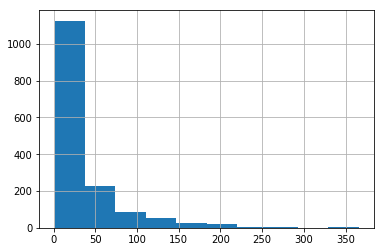

In [8]:
mace_annotation_df.turn_len.hist()

In [9]:
mace_annotation_df['turn_text'] = mace_annotation_df.apply(lambda row: {
                                            'author': row['turn_text']['author'], 
                                            'text' : row['topic'].replace('_', ' ') + ' [SEP] ' +  row['turn_text']['text']
                                           } ,axis=1)

In [10]:
mace_annotation_df = mace_annotation_df.groupby('task_id').agg({'turn_text': lambda rows: list(rows),
                                                                'topic': lambda rows: list(rows)[0],
                                                               'topic_func_label': lambda rows: list(rows),
                                                               'dlg_act_label': lambda rows: list(rows),
                                                               'exp_act_label': lambda rows: list(rows)}).reset_index()

In [11]:
mace_annotation_df['num_turns_per_topic'] = mace_annotation_df.topic_func_label.apply(lambda x : len(x))

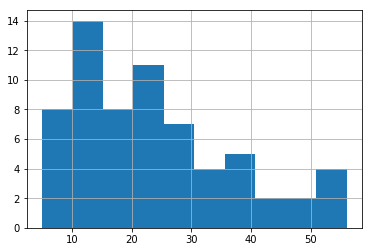

In [12]:
mace_annotation_df.num_turns_per_topic.hist()

In [13]:
mace_annotation_df.num_turns_per_topic.max()

56

In [14]:
mace_annotation_df.head()

,task_id,turn_text,topic,topic_func_label,dlg_act_label,exp_act_label,num_turns_per_topic
0,142,"[{'author': 'Explainer', 'text': 'virtual real...",virtual_reality,"[(T04) Other - No topic was introduced, (T01) ...","[(D09) To provide informing statement, (D09) T...","[(E02) Testing prior knowledge, (E03) Provide ...",12
1,143,"[{'author': 'Explainer', 'text': 'virtual real...",virtual_reality,"[(T01) It is the main topic, (T03) A related t...","[(D09) To provide informing statement, (D09) T...","[(E03) Provide an explanation, (E03) Provide a...",8
2,144,"[{'author': 'Explainer', 'text': 'virtual real...",virtual_reality,"[(T02) A subtopic, (T02) A subtopic, (T02) A s...","[(D01) To ask a check question, (D09) To provi...","[(E02) Testing prior knowledge, (E03) Provide ...",12
3,145,"[{'author': 'Explainer', 'text': 'virtual real...",virtual_reality,"[(T04) Other - No topic was introduced, (T04) ...","[(D01) To ask a check question, (D05) To answe...","[(E09) Introducing Extraneous Information, (E0...",5
4,146,"[{'author': 'Explainer', 'text': 'virtual real...",virtual_reality,"[(T01) It is the main topic, (T01) It is the m...","[(D01) To ask a check question, (D09) To provi...","[(E02) Testing prior knowledge, (E03) Provide ...",7


In [15]:
parser = argparse.ArgumentParser()
args = argparse.Namespace(turn_type='multi', pooling='cls', sp1_token='[EXPLAINER]', sp2_token='[EXPLAINEE]', bert_type='bert-base-uncased',
                          max_len=512, max_turns=56, dropout=0.1, context_d_ff=2048, context_num_heads=8, context_dropout=0.1, device='cuda',
                         context_num_layers=2, learning_rate=2e-5, warmup_ratio=0.01, batch_size=4, num_workers=2, num_epochs=5,
                         num_classes=-1, ckpt_dir='./cross-val-models')

### Train to predict the topic relation:

In [16]:
args.ckpt_dir='./topic_rel_models'
args.num_classes=4

In [17]:
label_clm = 'topic_func_label'

In [18]:
mace_annotation_df['label'] = mace_annotation_df[label_clm].apply(lambda labels: [int(x[2:4])-1 for x in labels]) #making labels parasable as integers
num_labels   = 4

In [19]:
topics = mace_annotation_df.topic.unique()
train_topics, valid_topics, test_topics = topics[:9], topics[9:11], topics[11:] 

training_df = mace_annotation_df[mace_annotation_df.topic.isin(train_topics)].copy()
valid_df = mace_annotation_df[mace_annotation_df.topic.isin(valid_topics)].copy()
test_df = mace_annotation_df[mace_annotation_df.topic.isin(test_topics)].copy()

In [20]:
args.num_classes= num_labels
args.pooling = 'cls'

In [17]:
model, eval_results = run_experiment(args, training_df, valid_df, test_df)

45it [00:00, 71.13it/s]
100%|██████████| 45/45 [00:00<00:00, 2173.44it/s]


1085 samples are prepared


10it [00:00, 79.29it/s]
100%|██████████| 10/10 [00:00<00:00, 2466.95it/s]


304 samples are prepared


10it [00:00, 96.04it/s]
100%|██████████| 10/10 [00:00<00:00, 3506.36it/s]


161 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 272/272 [01:26<00:00,  3.13it/s]


Train loss: 4.729980486719048 || Train accuracy: 0.8909598688604213 || Train F1 score: 0.8167320912415521
Validation processing...


100%|██████████| 76/76 [00:08<00:00,  9.28it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.49525065286574194
Validation loss: 27.72475867365536 || Validation accuracy: 0.6739692682184695 || Current validation F1 score: 0.49525065286574194
################################################## Epoch: 2 ##################################################


100%|██████████| 272/272 [01:25<00:00,  3.18it/s]


Train loss: 0.13722519357414806 || Train accuracy: 0.9985428935705178 || Train F1 score: 0.9971088273139594
Validation processing...


100%|██████████| 76/76 [00:08<00:00,  9.29it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5107919181639834
Validation loss: 32.55909515995728 || Validation accuracy: 0.6876616461280998 || Current validation F1 score: 0.5107919181639834
################################################## Epoch: 3 ##################################################


100%|██████████| 272/272 [01:25<00:00,  3.17it/s]


Train loss: 0.02341545855297762 || Train accuracy: 1.0 || Train F1 score: 1.0
Validation processing...


100%|██████████| 76/76 [00:08<00:00,  9.30it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5296665590619699
Validation loss: 35.76730707444643 || Validation accuracy: 0.7129164764947512 || Current validation F1 score: 0.5296665590619699
################################################## Epoch: 4 ##################################################


100%|██████████| 272/272 [01:25<00:00,  3.17it/s]


Train loss: 0.01695324436706655 || Train accuracy: 0.9999392872321049 || Train F1 score: 0.9999354592407983
Validation processing...


100%|██████████| 76/76 [00:08<00:00,  9.28it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5296665590619699
Validation loss: 36.713331263316306 || Validation accuracy: 0.7129164764947512 || Current validation F1 score: 0.5295970434635526
################################################## Epoch: 5 ##################################################


100%|██████████| 272/272 [01:25<00:00,  3.18it/s]


Train loss: 0.01567506045103073 || Train accuracy: 0.9999392872321049 || Train F1 score: 0.9999354400734756
Validation processing...


100%|██████████| 76/76 [00:08<00:00,  9.30it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.5296665590619699
Validation loss: 37.41182061559275 || Validation accuracy: 0.7033318119580101 || Current validation F1 score: 0.5210948125144332
Training finished!
Testing the model...


100%|██████████| 41/41 [00:04<00:00,  9.34it/s]

<Test Result>
Test accuracy: 0.6519495412844036 || Test F1 score: 0.4896265485444708
GOOD BYE.


### Train to predict dialog act:

In [18]:
args.ckpt_dir='./dlg_act_models'
args.num_classes=10

In [19]:
label_clm = 'dlg_act_label'
mace_annotation_df['label'] = mace_annotation_df[label_clm].apply(lambda labels: [int(x[2:4])-1 for x in labels]) #making labels parasable as integers

In [20]:
topics = mace_annotation_df.topic.unique()
train_topics, valid_topics, test_topics = topics[:9], topics[9:11], topics[11:] 

training_df = mace_annotation_df[mace_annotation_df.topic.isin(train_topics)].copy()
valid_df = mace_annotation_df[mace_annotation_df.topic.isin(valid_topics)].copy()
test_df = mace_annotation_df[mace_annotation_df.topic.isin(test_topics)].copy()

In [21]:
_,_,test_ds, model = run_experiment(args, training_df, valid_df, test_df)

45it [00:00, 71.59it/s]
100%|██████████| 45/45 [00:00<00:00, 2815.31it/s]


1085 samples are prepared


10it [00:00, 83.07it/s]
100%|██████████| 10/10 [00:00<00:00, 3187.65it/s]


304 samples are prepared


10it [00:00, 96.82it/s]
100%|██████████| 10/10 [00:00<00:00, 4511.94it/s]


161 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 272/272 [01:25<00:00,  3.17it/s]


Train loss: 6.241877886740601 || Train accuracy: 0.8691639851860846 || Train F1 score: 0.6947246702814068
Validation processing...


100%|██████████| 76/76 [00:08<00:00,  9.25it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.38777356626244763
Validation loss: 25.411744685549486 || Validation accuracy: 0.7600791115168112 || Current validation F1 score: 0.38777356626244763
################################################## Epoch: 2 ##################################################


100%|██████████| 272/272 [01:25<00:00,  3.17it/s]


Train loss: 0.7286375471774269 || Train accuracy: 0.9864610527593953 || Train F1 score: 0.9758050685143548
Validation processing...


100%|██████████| 76/76 [00:08<00:00,  9.25it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4055443616760668
Validation loss: 31.127505431049748 || Validation accuracy: 0.7567320858055683 || Current validation F1 score: 0.4055443616760668
################################################## Epoch: 3 ##################################################


100%|██████████| 272/272 [01:25<00:00,  3.17it/s]


Train loss: 0.4160263025585343 || Train accuracy: 0.9906502337441564 || Train F1 score: 0.9822992970165144
Validation processing...


100%|██████████| 76/76 [00:08<00:00,  9.25it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.4055443616760668
Validation loss: 33.12115798498455 || Validation accuracy: 0.7501901719154115 || Current validation F1 score: 0.3985005502207797
################################################## Epoch: 4 ##################################################


100%|██████████| 272/272 [01:25<00:00,  3.17it/s]


Train loss: 0.3552391178467694 || Train accuracy: 0.9913180741910024 || Train F1 score: 0.9826403415494397
Validation processing...


100%|██████████| 76/76 [00:08<00:00,  9.25it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.4055443616760668
Validation loss: 33.514348472419535 || Validation accuracy: 0.7361935189411227 || Current validation F1 score: 0.3973697306892313
################################################## Epoch: 5 ##################################################


100%|██████████| 272/272 [01:25<00:00,  3.17it/s]


Train loss: 0.3424823249087614 || Train accuracy: 0.9918644891020582 || Train F1 score: 0.9841791013248103
Validation processing...


100%|██████████| 76/76 [00:08<00:00,  9.26it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.4055443616760668
Validation loss: 33.84368492427625 || Validation accuracy: 0.7416704701049749 || Current validation F1 score: 0.3996507823576091
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 41/41 [00:04<00:00,  9.29it/s]

<Test Result>
Test accuracy: 0.6989678899082569 || Test F1 score: 0.3751085610817345
GOOD BYE.


### Train to predict explanation act:

In [22]:
args.ckpt_dir='./exp_act_models'
args.num_classes=10

In [23]:
label_clm = 'exp_act_label'
mace_annotation_df['label'] = mace_annotation_df[label_clm].apply(lambda labels: [int(x[2:4])-1 for x in labels]) #making labels parasable as integers

In [24]:
topics = mace_annotation_df.topic.unique()
train_topics, valid_topics, test_topics = topics[:9], topics[9:11], topics[11:] 

training_df = mace_annotation_df[mace_annotation_df.topic.isin(train_topics)].copy()
valid_df = mace_annotation_df[mace_annotation_df.topic.isin(valid_topics)].copy()
test_df = mace_annotation_df[mace_annotation_df.topic.isin(test_topics)].copy()

In [25]:
_,_,test_ds, model = run_experiment(args, training_df, valid_df, test_df)

45it [00:00, 70.68it/s]
100%|██████████| 45/45 [00:00<00:00, 3047.89it/s]


1085 samples are prepared


10it [00:00, 81.24it/s]
100%|██████████| 10/10 [00:00<00:00, 2814.97it/s]


304 samples are prepared


10it [00:00, 97.42it/s]
100%|██████████| 10/10 [00:00<00:00, 4462.03it/s]


161 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 272/272 [01:25<00:00,  3.17it/s]


Train loss: 7.761383688186898 || Train accuracy: 0.8393540161495963 || Train F1 score: 0.7231264484872216
Validation processing...


100%|██████████| 76/76 [00:08<00:00,  9.22it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.38127604777345375
Validation loss: 30.589024412004573 || Validation accuracy: 0.6233074699528374 || Current validation F1 score: 0.38127604777345375
################################################## Epoch: 2 ##################################################


100%|██████████| 272/272 [01:25<00:00,  3.17it/s]


Train loss: 0.8876243540469337 || Train accuracy: 0.98281828668569 || Train F1 score: 0.9769481642654082
Validation processing...


100%|██████████| 76/76 [00:08<00:00,  9.25it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.38127604777345375
Validation loss: 35.36612358218745 || Validation accuracy: 0.6214818195648867 || Current validation F1 score: 0.353015964915239
################################################## Epoch: 3 ##################################################


100%|██████████| 272/272 [01:25<00:00,  3.17it/s]


Train loss: 0.5188134400283589 || Train accuracy: 0.9881610102604578 || Train F1 score: 0.9856780748787616
Validation processing...


100%|██████████| 76/76 [00:08<00:00,  9.24it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.3875904623019878
Validation loss: 40.222317808552795 || Validation accuracy: 0.6117450174958162 || Current validation F1 score: 0.3875904623019878
################################################## Epoch: 4 ##################################################


100%|██████████| 272/272 [01:25<00:00,  3.17it/s]


Train loss: 0.4192621142548673 || Train accuracy: 0.9900431060652055 || Train F1 score: 0.9891245464491967
Validation processing...


100%|██████████| 76/76 [00:08<00:00,  9.25it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.39641710461806695
Validation loss: 40.503324925899506 || Validation accuracy: 0.6042902784116841 || Current validation F1 score: 0.39641710461806695
################################################## Epoch: 5 ##################################################


100%|██████████| 272/272 [01:25<00:00,  3.17it/s]


Train loss: 0.38966065163121505 || Train accuracy: 0.9905895209762613 || Train F1 score: 0.9888026590174827
Validation processing...


100%|██████████| 76/76 [00:08<00:00,  9.25it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.39641710461806695
Validation loss: 40.611523032188416 || Validation accuracy: 0.6120492925604747 || Current validation F1 score: 0.37998473551596185
Training finished!
Testing the model...


100%|██████████| 41/41 [00:04<00:00,  9.28it/s]

<Test Result>
Test accuracy: 0.7064220183486238 || Test F1 score: 0.3767899557577234
GOOD BYE.


### Train 13 models for each class:

In [16]:
def cross_topic_eval(args, df, label_clm, input_clm, output_dir):
    num_labels = df[label_clm].nunique()
    
    args.num_classes = num_labels
    
    df = df.groupby('task_id').agg({'turn_text': lambda rows: list(rows),
                                    'topic': lambda rows: list(rows)[0],
                                    'topic_func_label': lambda rows: list(rows),
                                    'dlg_act_label': lambda rows: list(rows),
                                    'exp_act_label': lambda rows: list(rows)}).reset_index()
    
    df['label'] = df[label_clm].apply(lambda labels: [int(x[2:4])-1 for x in labels]) #making labels parasable as integers
    
    topics = df.topic.unique() #Train and evaluate one model for each topic...
    all_eval_results = {}
    for topic in topics:
        print(topic)
        training_df= df[df.topic != topic]
        
        #split the training df to further training and validation per topic
        train_topics = training_df.topic.unique()
        train_topics, test_topics = train_test_split(train_topics, test_size=2)
        
        new_training_df = training_df[training_df.topic.isin(train_topics)].copy()
        valid_df    = training_df[training_df.topic.isin(test_topics)].copy()
        test_df     = df[df.topic == topic].copy()
        
        args.ckpt_dir = output_dir + '/model_{}'.format(topic)
        
        model, eval_results = run_experiment(args, new_training_df, valid_df, test_df)
        
        all_eval_results[topic] = eval_results

    return all_eval_results

In [17]:
mace_annotation_df = pd.read_pickle('../data/annotation-results/MACE-measure/final_mace_predictions.pkl')
mace_annotation_df['turn_text'] = mace_annotation_df.apply(lambda row: {
                                            'author': row['turn_text']['author'], 
                                            'text' : row['topic'].replace('_', ' ') + ' [SEP] ' +  row['turn_text']['text']
                                           } ,axis=1)

In [18]:
parser = argparse.ArgumentParser()
args = argparse.Namespace(turn_type='multi', pooling='cls', sp1_token='[EXPLAINER]', sp2_token='[EXPLAINEE]', bert_type='bert-base-uncased',
                          max_len=128, max_turns=56, dropout=0.1, context_d_ff=2048, context_num_heads=8, context_dropout=0.1, device='cuda',
                         context_num_layers=2, learning_rate=2e-5, warmup_ratio=0.01, batch_size=2, num_workers=2, num_epochs=5,
                         num_classes=-1, ckpt_dir='topic-func-cross-val-models')

In [19]:
eval_results = cross_topic_eval(args, mace_annotation_df.copy(), 'topic_func_label', 'turn_text', './topic-func-cross-val-models')

virtual_reality


50it [00:00, 68.59it/s]
100%|██████████| 50/50 [00:00<00:00, 2560.09it/s]


1217 samples are prepared


10it [00:00, 59.89it/s]
100%|██████████| 10/10 [00:00<00:00, 2823.50it/s]


289 samples are prepared


5it [00:00, 94.46it/s]
100%|██████████| 5/5 [00:00<00:00, 4158.54it/s]


44 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 609/609 [02:09<00:00,  4.70it/s]


Train loss: 3.8229623894973344 || Train accuracy: 0.9177160336477186 || Train F1 score: 0.8750957445272125
Validation processing...


100%|██████████| 145/145 [00:10<00:00, 14.42it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.49183795029031296
Validation loss: 14.306211249581699 || Validation accuracy: 0.7923771313941825 || Current validation F1 score: 0.49183795029031296
################################################## Epoch: 2 ##################################################


100%|██████████| 609/609 [02:07<00:00,  4.79it/s]


Train loss: 0.08857198889032374 || Train accuracy: 0.9991333163395361 || Train F1 score: 0.9982525744957872
Validation processing...


100%|██████████| 145/145 [00:10<00:00, 14.37it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.54300566300659
Validation loss: 17.45679234307388 || Validation accuracy: 0.8034102306920762 || Current validation F1 score: 0.54300566300659
################################################## Epoch: 3 ##################################################


100%|██████████| 609/609 [02:07<00:00,  4.79it/s]


Train loss: 0.02318460600716727 || Train accuracy: 0.999847055824624 || Train F1 score: 0.9996384665998556
Validation processing...


100%|██████████| 145/145 [00:10<00:00, 14.40it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5636902517690668
Validation loss: 17.289694771273382 || Validation accuracy: 0.8238716148445336 || Current validation F1 score: 0.5636902517690668
################################################## Epoch: 4 ##################################################


100%|██████████| 609/609 [02:07<00:00,  4.77it/s]


Train loss: 0.012331803248237898 || Train accuracy: 1.0 || Train F1 score: 1.0
Validation processing...


100%|██████████| 145/145 [00:10<00:00, 14.32it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5636902517690668
Validation loss: 17.925051357006204 || Validation accuracy: 0.8128385155466399 || Current validation F1 score: 0.5117612001401388
################################################## Epoch: 5 ##################################################


100%|██████████| 609/609 [02:07<00:00,  4.77it/s]


Train loss: 0.01031545034574562 || Train accuracy: 1.0 || Train F1 score: 1.0
Validation processing...


100%|██████████| 145/145 [00:10<00:00, 14.37it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.5636902517690668
Validation loss: 18.05104034851337 || Validation accuracy: 0.8116349047141425 || Current validation F1 score: 0.5102969403009638
Training finished!
Testing the model...


100%|██████████| 22/22 [00:01<00:00, 13.02it/s]


<Test Result>
Test accuracy: 0.6340425531914894 || Test F1 score: 0.6352568633025539
GOOD BYE.
sleep_scientist


50it [00:00, 71.87it/s]
100%|██████████| 50/50 [00:00<00:00, 2391.82it/s]


1211 samples are prepared


10it [00:00, 60.55it/s]
100%|██████████| 10/10 [00:00<00:00, 2827.87it/s]


192 samples are prepared


5it [00:00, 61.77it/s]
100%|██████████| 5/5 [00:00<00:00, 1997.86it/s]


147 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 606/606 [02:06<00:00,  4.79it/s]


Train loss: 3.858719926757781 || Train accuracy: 0.913548964078104 || Train F1 score: 0.8678063026689756
Validation processing...


100%|██████████| 96/96 [00:06<00:00, 14.27it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4806165289399048
Validation loss: 16.545739598572254 || Validation accuracy: 0.6343612334801763 || Current validation F1 score: 0.4806165289399048
################################################## Epoch: 2 ##################################################


100%|██████████| 606/606 [02:06<00:00,  4.79it/s]


Train loss: 0.08204453318032494 || Train accuracy: 0.9993044169523526 || Train F1 score: 0.998672063397479
Validation processing...


100%|██████████| 96/96 [00:06<00:00, 14.28it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.4806165289399048
Validation loss: 20.30468901246786 || Validation accuracy: 0.6304454233969653 || Current validation F1 score: 0.4701912349060854
################################################## Epoch: 3 ##################################################


100%|██████████| 606/606 [02:06<00:00,  4.79it/s]


Train loss: 0.022980019204293933 || Train accuracy: 0.9998509464897898 || Train F1 score: 0.9996734867621787
Validation processing...


100%|██████████| 96/96 [00:06<00:00, 14.25it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.4806165289399048
Validation loss: 21.457243010401726 || Validation accuracy: 0.6186979931473323 || Current validation F1 score: 0.4581194238917934
################################################## Epoch: 4 ##################################################


100%|██████████| 606/606 [02:06<00:00,  4.78it/s]


Train loss: 0.01068346925301127 || Train accuracy: 1.0 || Train F1 score: 1.0
Validation processing...


100%|██████████| 96/96 [00:06<00:00, 14.26it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.4806165289399048
Validation loss: 21.764163029690582 || Validation accuracy: 0.6191874694077337 || Current validation F1 score: 0.45880106158217693
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 74/74 [00:05<00:00, 14.07it/s]


<Test Result>
Test accuracy: 0.7876172607879925 || Test F1 score: 0.4252844929132622
GOOD BYE.
origani


50it [00:00, 65.36it/s]
100%|██████████| 50/50 [00:00<00:00, 3139.31it/s]


1278 samples are prepared


10it [00:00, 88.50it/s]
100%|██████████| 10/10 [00:00<00:00, 3086.77it/s]


160 samples are prepared


5it [00:00, 78.50it/s]
100%|██████████| 5/5 [00:00<00:00, 2759.41it/s]


112 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 639/639 [02:13<00:00,  4.78it/s]


Train loss: 3.7647091766851424 || Train accuracy: 0.9189164621398055 || Train F1 score: 0.862526902080124
Validation processing...


100%|██████████| 80/80 [00:05<00:00, 14.18it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4849658086694806
Validation loss: 14.956509657204151 || Validation accuracy: 0.6162790697674418 || Current validation F1 score: 0.4849658086694806
################################################## Epoch: 2 ##################################################


100%|██████████| 639/639 [02:13<00:00,  4.79it/s]


Train loss: 0.0721990573387564 || Train accuracy: 0.999227342968821 || Train F1 score: 0.9989779057813941
Validation processing...


100%|██████████| 80/80 [00:05<00:00, 14.15it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.4849658086694806
Validation loss: 16.969227918982504 || Validation accuracy: 0.6101231190150479 || Current validation F1 score: 0.478828629998064
################################################## Epoch: 3 ##################################################


100%|██████████| 639/639 [02:13<00:00,  4.78it/s]


Train loss: 0.013976744829395754 || Train accuracy: 1.0 || Train F1 score: 1.0
Validation processing...


100%|██████████| 80/80 [00:05<00:00, 14.16it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.4849658086694806
Validation loss: 19.81179086267948 || Validation accuracy: 0.63406292749658 || Current validation F1 score: 0.47725628454768143
################################################## Epoch: 4 ##################################################


100%|██████████| 639/639 [02:13<00:00,  4.77it/s]


Train loss: 0.008490964280607555 || Train accuracy: 1.0 || Train F1 score: 1.0
Validation processing...


100%|██████████| 80/80 [00:05<00:00, 14.18it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.4849658086694806
Validation loss: 20.069546952843666 || Validation accuracy: 0.6313269493844049 || Current validation F1 score: 0.47560466164310344
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 56/56 [00:04<00:00, 13.93it/s]


<Test Result>
Test accuracy: 0.7169948942377826 || Test F1 score: 0.458488412043978
GOOD BYE.
nano_technology


50it [00:00, 71.23it/s]
100%|██████████| 50/50 [00:00<00:00, 3196.63it/s]


1144 samples are prepared


10it [00:00, 60.76it/s]
100%|██████████| 10/10 [00:00<00:00, 2101.04it/s]


314 samples are prepared


5it [00:00, 62.36it/s]
100%|██████████| 5/5 [00:00<00:00, 2645.25it/s]


92 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 572/572 [01:59<00:00,  4.78it/s]


Train loss: 3.190528557225541 || Train accuracy: 0.9169764560099133 || Train F1 score: 0.8641333873627043
Validation processing...


100%|██████████| 157/157 [00:10<00:00, 14.34it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4638504299118131
Validation loss: 29.615445481743784 || Validation accuracy: 0.6720266550775026 || Current validation F1 score: 0.4638504299118131
################################################## Epoch: 2 ##################################################


100%|██████████| 572/572 [02:03<00:00,  4.62it/s]


Train loss: 0.08325569404588713 || Train accuracy: 0.9990558800967723 || Train F1 score: 0.9979866724206484
Validation processing...


100%|██████████| 157/157 [00:11<00:00, 14.14it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.46926814112672005
Validation loss: 37.64978105399259 || Validation accuracy: 0.6794147472113574 || Current validation F1 score: 0.46926814112672005
################################################## Epoch: 3 ##################################################


100%|██████████| 572/572 [02:12<00:00,  4.31it/s]


Train loss: 0.015336732347528418 || Train accuracy: 0.9999409925060483 || Train F1 score: 0.9999378355146751
Validation processing...


100%|██████████| 157/157 [00:12<00:00, 12.81it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4987274008996543
Validation loss: 35.141426955059075 || Validation accuracy: 0.7251919455309286 || Current validation F1 score: 0.4987274008996543
################################################## Epoch: 4 ##################################################


100%|██████████| 572/572 [02:13<00:00,  4.28it/s]


Train loss: 0.014214391058141535 || Train accuracy: 0.9999409925060483 || Train F1 score: 0.9999224546528075
Validation processing...


100%|██████████| 157/157 [00:12<00:00, 12.83it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5572337222466157
Validation loss: 35.28878472413227 || Validation accuracy: 0.7318557149065623 || Current validation F1 score: 0.5572337222466157
################################################## Epoch: 5 ##################################################


100%|██████████| 572/572 [02:09<00:00,  4.43it/s]


Train loss: 0.00760197639465332 || Train accuracy: 1.0 || Train F1 score: 1.0
Validation processing...


100%|██████████| 157/157 [00:12<00:00, 12.54it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5572337222466157
Validation loss: 35.85551713986002 || Validation accuracy: 0.727509778357236 || Current validation F1 score: 0.552756543298321
Training finished!
Testing the model...


100%|██████████| 46/46 [00:03<00:00, 11.83it/s]


<Test Result>
Test accuracy: 0.7817258883248731 || Test F1 score: 0.5851021911199268
GOOD BYE.
music_harmony


50it [00:01, 45.30it/s]
100%|██████████| 50/50 [00:00<00:00, 2641.45it/s]


977 samples are prepared


10it [00:00, 28.12it/s]
100%|██████████| 10/10 [00:00<00:00, 1482.03it/s]


423 samples are prepared


5it [00:00, 59.81it/s]
100%|██████████| 5/5 [00:00<00:00, 2098.83it/s]


150 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 489/489 [01:53<00:00,  4.29it/s]


Train loss: 3.07910041434877 || Train accuracy: 0.9136679038244312 || Train F1 score: 0.8539104407975283
Validation processing...


100%|██████████| 212/212 [00:16<00:00, 12.83it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4636194658696781
Validation loss: 31.448910305522524 || Validation accuracy: 0.6602805695142379 || Current validation F1 score: 0.4636194658696781
################################################## Epoch: 2 ##################################################


100%|██████████| 489/489 [01:52<00:00,  4.36it/s]


Train loss: 0.08624939294436715 || Train accuracy: 0.9987090527674681 || Train F1 score: 0.9973371537458701
Validation processing...


100%|██████████| 212/212 [00:14<00:00, 14.43it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.4636194658696781
Validation loss: 39.569082809506725 || Validation accuracy: 0.6623743718592965 || Current validation F1 score: 0.45671547695281434
################################################## Epoch: 3 ##################################################


100%|██████████| 489/489 [01:53<00:00,  4.33it/s]


Train loss: 0.01905547524278637 || Train accuracy: 0.9998386315959336 || Train F1 score: 0.9995792871946607
Validation processing...


100%|██████████| 212/212 [00:16<00:00, 12.63it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.4636194658696781
Validation loss: 41.998332934559514 || Validation accuracy: 0.6542085427135679 || Current validation F1 score: 0.44759324489966423
################################################## Epoch: 4 ##################################################


100%|██████████| 489/489 [01:54<00:00,  4.28it/s]


Train loss: 0.011004840425674657 || Train accuracy: 1.0 || Train F1 score: 1.0
Validation processing...


100%|██████████| 212/212 [00:16<00:00, 12.93it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.4636194658696781
Validation loss: 42.55881347521296 || Validation accuracy: 0.6511725293132329 || Current validation F1 score: 0.447756592134251
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 75/75 [00:06<00:00, 12.36it/s]


<Test Result>
Test accuracy: 0.7902388369678089 || Test F1 score: 0.5316834283447458
GOOD BYE.
machine_learning


50it [00:01, 41.09it/s]
100%|██████████| 50/50 [00:00<00:00, 2153.38it/s]


1229 samples are prepared


10it [00:00, 58.00it/s]
100%|██████████| 10/10 [00:00<00:00, 2710.55it/s]


202 samples are prepared


5it [00:00, 40.09it/s]
100%|██████████| 5/5 [00:00<00:00, 1996.91it/s]


119 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 615/615 [02:19<00:00,  4.42it/s]


Train loss: 3.979158485420351 || Train accuracy: 0.9094589979999025 || Train F1 score: 0.8506268043795229
Validation processing...


100%|██████████| 101/101 [00:07<00:00, 12.66it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5043957227327296
Validation loss: 13.82006026494621 || Validation accuracy: 0.7588105726872246 || Current validation F1 score: 0.5043957227327296
################################################## Epoch: 2 ##################################################


100%|██████████| 615/615 [02:23<00:00,  4.29it/s]


Train loss: 0.06534823092018685 || Train accuracy: 0.9995121713254305 || Train F1 score: 0.9991283289764044
Validation processing...


100%|██████████| 101/101 [00:07<00:00, 12.79it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5043957227327296
Validation loss: 15.824749002362243 || Validation accuracy: 0.7463289280469897 || Current validation F1 score: 0.49967159673047823
################################################## Epoch: 3 ##################################################


100%|██████████| 615/615 [02:24<00:00,  4.25it/s]


Train loss: 0.023354848613583945 || Train accuracy: 0.9998048685301723 || Train F1 score: 0.999690906738347
Validation processing...


100%|██████████| 101/101 [00:08<00:00, 12.18it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.5043957227327296
Validation loss: 15.819926014040956 || Validation accuracy: 0.750367107195301 || Current validation F1 score: 0.5032330470863781
################################################## Epoch: 4 ##################################################


100%|██████████| 615/615 [02:19<00:00,  4.39it/s]


Train loss: 0.01145519822593627 || Train accuracy: 0.9999512171325431 || Train F1 score: 0.9999390580110105
Validation processing...


100%|██████████| 101/101 [00:08<00:00, 12.55it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5104624878011618
Validation loss: 16.02945083674818 || Validation accuracy: 0.7646842878120411 || Current validation F1 score: 0.5104624878011618
################################################## Epoch: 5 ##################################################


100%|██████████| 615/615 [02:33<00:00,  4.00it/s]


Train loss: 0.00929192294919394 || Train accuracy: 0.9999512171325431 || Train F1 score: 0.9998216212574509
Validation processing...


100%|██████████| 101/101 [00:08<00:00, 12.33it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5106527303036623
Validation loss: 16.045299907722097 || Validation accuracy: 0.7646842878120411 || Current validation F1 score: 0.5106527303036623
Training finished!
Testing the model...


100%|██████████| 60/60 [00:04<00:00, 12.39it/s]


<Test Result>
Test accuracy: 0.7090570719602978 || Test F1 score: 0.49394891743126434
GOOD BYE.
lasers


50it [00:01, 36.84it/s]
100%|██████████| 50/50 [00:00<00:00, 833.08it/s]


1216 samples are prepared


10it [00:00, 37.95it/s]
100%|██████████| 10/10 [00:00<00:00, 2241.86it/s]


192 samples are prepared


5it [00:00, 36.43it/s]
100%|██████████| 5/5 [00:00<00:00, 1701.27it/s]


142 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 608/608 [02:29<00:00,  4.06it/s]


Train loss: 2.9946563794816794 || Train accuracy: 0.9352286049237983 || Train F1 score: 0.8960284709988877
Validation processing...


100%|██████████| 96/96 [00:07<00:00, 12.40it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5014134194486009
Validation loss: 15.406030389169851 || Validation accuracy: 0.6558981889378365 || Current validation F1 score: 0.5014134194486009
################################################## Epoch: 2 ##################################################


100%|██████████| 608/608 [02:11<00:00,  4.64it/s]


Train loss: 0.08337813625602346 || Train accuracy: 0.9993161391168425 || Train F1 score: 0.9988430590462473
Validation processing...


100%|██████████| 96/96 [00:06<00:00, 14.20it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5016943427163785
Validation loss: 18.084252727528412 || Validation accuracy: 0.6465981399902104 || Current validation F1 score: 0.5016943427163785
################################################## Epoch: 3 ##################################################


100%|██████████| 608/608 [02:07<00:00,  4.78it/s]


Train loss: 0.023862682871128384 || Train accuracy: 0.9998534583821805 || Train F1 score: 0.99964488283525
Validation processing...


100%|██████████| 96/96 [00:06<00:00, 14.25it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5016943427163785
Validation loss: 19.08303740868966 || Validation accuracy: 0.6544297601566325 || Current validation F1 score: 0.5009420203831239
################################################## Epoch: 4 ##################################################


100%|██████████| 608/608 [02:07<00:00,  4.78it/s]


Train loss: 0.012332672351285032 || Train accuracy: 0.9999023055881203 || Train F1 score: 0.9997098288873927
Validation processing...


100%|██████████| 96/96 [00:06<00:00, 14.21it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5023631307372797
Validation loss: 18.74174703657627 || Validation accuracy: 0.6510034263338228 || Current validation F1 score: 0.5023631307372797
################################################## Epoch: 5 ##################################################


100%|██████████| 608/608 [02:07<00:00,  4.78it/s]


Train loss: 0.011057409800981221 || Train accuracy: 0.9999511527940602 || Train F1 score: 0.9999650649627585
Validation processing...


100%|██████████| 96/96 [00:06<00:00, 14.24it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5023631307372797
Validation loss: 18.904682852327824 || Validation accuracy: 0.6544297601566325 || Current validation F1 score: 0.502220348158692
Training finished!
Testing the model...


100%|██████████| 71/71 [00:05<00:00, 13.96it/s]


<Test Result>
Test accuracy: 0.803448275862069 || Test F1 score: 0.5551892716606869
GOOD BYE.
hacking


50it [00:00, 74.83it/s]
100%|██████████| 50/50 [00:00<00:00, 2761.92it/s]


1159 samples are prepared


10it [00:00, 53.59it/s]
100%|██████████| 10/10 [00:00<00:00, 2251.01it/s]


291 samples are prepared


5it [00:00, 57.40it/s]
100%|██████████| 5/5 [00:00<00:00, 2179.31it/s]


100 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 580/580 [02:01<00:00,  4.79it/s]


Train loss: 3.1679712213318925 || Train accuracy: 0.9297075961992756 || Train F1 score: 0.877085585142874
Validation processing...


100%|██████████| 146/146 [00:10<00:00, 14.39it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5087817388589818
Validation loss: 17.715456248962717 || Validation accuracy: 0.6759729272419628 || Current validation F1 score: 0.5087817388589818
################################################## Epoch: 2 ##################################################


100%|██████████| 580/580 [02:01<00:00,  4.78it/s]


Train loss: 0.08541301858836207 || Train accuracy: 0.9994225418657148 || Train F1 score: 0.9985298673271078
Validation processing...


100%|██████████| 146/146 [00:10<00:00, 14.42it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5087817388589818
Validation loss: 22.45874797971281 || Validation accuracy: 0.68168358714044 || Current validation F1 score: 0.4951490841988082
################################################## Epoch: 3 ##################################################


100%|██████████| 580/580 [02:01<00:00,  4.78it/s]


Train loss: 0.01999378697625522 || Train accuracy: 0.9998950076119482 || Train F1 score: 0.9996285933470181
Validation processing...


100%|██████████| 146/146 [00:10<00:00, 14.41it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.5087817388589818
Validation loss: 24.418640994045834 || Validation accuracy: 0.6774534686971235 || Current validation F1 score: 0.49148154202107314
################################################## Epoch: 4 ##################################################


100%|██████████| 580/580 [02:01<00:00,  4.79it/s]


Train loss: 0.013069236278533935 || Train accuracy: 1.0 || Train F1 score: 1.0
Validation processing...


100%|██████████| 146/146 [00:10<00:00, 14.37it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.5087817388589818
Validation loss: 24.70245522587267 || Validation accuracy: 0.6749153976311336 || Current validation F1 score: 0.48841593291353946
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 50/50 [00:03<00:00, 13.75it/s]


<Test Result>
Test accuracy: 0.5623818525519849 || Test F1 score: 0.4324014969025405
GOOD BYE.
gravity


50it [00:00, 72.26it/s]
100%|██████████| 50/50 [00:00<00:00, 3230.06it/s]


1074 samples are prepared


10it [00:00, 74.34it/s]
100%|██████████| 10/10 [00:00<00:00, 2548.64it/s]


297 samples are prepared


5it [00:00, 39.29it/s]
100%|██████████| 5/5 [00:00<00:00, 1422.18it/s]


179 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 537/537 [01:52<00:00,  4.78it/s]


Train loss: 3.290063733384152 || Train accuracy: 0.9201833710123085 || Train F1 score: 0.8699348071920905
Validation processing...


100%|██████████| 149/149 [00:10<00:00, 14.39it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4679771082586852
Validation loss: 19.883324221476613 || Validation accuracy: 0.7589124954987396 || Current validation F1 score: 0.4679771082586852
################################################## Epoch: 2 ##################################################


100%|██████████| 537/537 [01:52<00:00,  4.78it/s]


Train loss: 0.10397549092880619 || Train accuracy: 0.9988696307460437 || Train F1 score: 0.997965817458213
Validation processing...


100%|██████████| 149/149 [00:10<00:00, 14.39it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.4679771082586852
Validation loss: 21.76904285994152 || Validation accuracy: 0.7518905293482175 || Current validation F1 score: 0.44208040392059833
################################################## Epoch: 3 ##################################################


100%|██████████| 537/537 [01:52<00:00,  4.78it/s]


Train loss: 0.018845218963907194 || Train accuracy: 0.9999372017081135 || Train F1 score: 0.9999586539793612
Validation processing...


100%|██████████| 149/149 [00:10<00:00, 14.36it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.4679771082586852
Validation loss: 23.6938847823431 || Validation accuracy: 0.7479294202376665 || Current validation F1 score: 0.42353970797698426
################################################## Epoch: 4 ##################################################


100%|██████████| 537/537 [01:52<00:00,  4.78it/s]


Train loss: 0.011846891772591645 || Train accuracy: 0.9999372017081135 || Train F1 score: 0.9999586539793612
Validation processing...


100%|██████████| 149/149 [00:10<00:00, 14.36it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.4679771082586852
Validation loss: 24.431775734728614 || Validation accuracy: 0.7509902772776378 || Current validation F1 score: 0.43241484773593974
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 90/90 [00:06<00:00, 14.18it/s]


<Test Result>
Test accuracy: 0.6380697050938338 || Test F1 score: 0.44448663743273853
GOOD BYE.
dimensions


50it [00:00, 70.60it/s]
100%|██████████| 50/50 [00:00<00:00, 2641.12it/s]


1143 samples are prepared


10it [00:00, 77.10it/s]
100%|██████████| 10/10 [00:00<00:00, 4240.95it/s]


163 samples are prepared


5it [00:00, 45.82it/s]
100%|██████████| 5/5 [00:00<00:00, 1332.63it/s]


244 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 572/572 [01:59<00:00,  4.78it/s]


Train loss: 3.367531915071544 || Train accuracy: 0.9163937354850236 || Train F1 score: 0.863489658436276
Validation processing...


100%|██████████| 82/82 [00:05<00:00, 14.18it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5136334591454101
Validation loss: 12.890496221984305 || Validation accuracy: 0.7065511640498106 || Current validation F1 score: 0.5136334591454101
################################################## Epoch: 2 ##################################################


100%|██████████| 572/572 [01:59<00:00,  4.77it/s]


Train loss: 0.08884545597996744 || Train accuracy: 0.9989281248139106 || Train F1 score: 0.9979979771482971
Validation processing...


100%|██████████| 82/82 [00:05<00:00, 14.20it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5297658858963201
Validation loss: 13.405444015816945 || Validation accuracy: 0.7146724417975094 || Current validation F1 score: 0.5297658858963201
################################################## Epoch: 3 ##################################################


100%|██████████| 572/572 [01:59<00:00,  4.78it/s]


Train loss: 0.01953534979920287 || Train accuracy: 0.9999404513785506 || Train F1 score: 0.9999255474579711
Validation processing...


100%|██████████| 82/82 [00:05<00:00, 14.19it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5297658858963201
Validation loss: 15.946506083011627 || Validation accuracy: 0.7141310232809962 || Current validation F1 score: 0.5188900025710371
################################################## Epoch: 4 ##################################################


100%|██████████| 572/572 [01:59<00:00,  4.78it/s]


Train loss: 0.012859414924274792 || Train accuracy: 0.9999404513785506 || Train F1 score: 0.9999580401292514
Validation processing...


100%|██████████| 82/82 [00:05<00:00, 14.21it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.5297658858963201
Validation loss: 15.674867345065605 || Validation accuracy: 0.7087168381158636 || Current validation F1 score: 0.5101502056747187
################################################## Epoch: 5 ##################################################


100%|██████████| 572/572 [01:59<00:00,  4.79it/s]


Train loss: 0.009510068209854873 || Train accuracy: 1.0 || Train F1 score: 1.0
Validation processing...


100%|██████████| 82/82 [00:05<00:00, 14.22it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.5297658858963201
Validation loss: 15.926926037160362 || Validation accuracy: 0.7125067677314564 || Current validation F1 score: 0.5112766671134954
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 122/122 [00:08<00:00, 14.22it/s]


<Test Result>
Test accuracy: 0.7023405972558515 || Test F1 score: 0.4605029032397488
GOOD BYE.
connectome


50it [00:00, 66.65it/s]
100%|██████████| 50/50 [00:00<00:00, 3189.25it/s]


1155 samples are prepared


10it [00:00, 61.37it/s]
100%|██████████| 10/10 [00:00<00:00, 2163.13it/s]


335 samples are prepared


5it [00:00, 170.66it/s]
100%|██████████| 5/5 [00:00<00:00, 5175.60it/s]


60 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 578/578 [02:00<00:00,  4.79it/s]


Train loss: 3.0066624181699586 || Train accuracy: 0.9296511627906977 || Train F1 score: 0.8779770275366603
Validation processing...


100%|██████████| 168/168 [00:11<00:00, 14.35it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4986449037366645
Validation loss: 24.29331879104887 || Validation accuracy: 0.7173281703775412 || Current validation F1 score: 0.4986449037366645
################################################## Epoch: 2 ##################################################


100%|██████████| 578/578 [02:00<00:00,  4.78it/s]


Train loss: 0.06969159078433027 || Train accuracy: 0.9994186046511628 || Train F1 score: 0.9989280873847649
Validation processing...


100%|██████████| 168/168 [00:11<00:00, 14.42it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5050066893048594
Validation loss: 27.936275377160026 || Validation accuracy: 0.7418061125708754 || Current validation F1 score: 0.5050066893048594
################################################## Epoch: 3 ##################################################


100%|██████████| 578/578 [02:00<00:00,  4.79it/s]


Train loss: 0.02012816226193649 || Train accuracy: 0.9998255813953488 || Train F1 score: 0.9997010359150965
Validation processing...


100%|██████████| 168/168 [00:11<00:00, 14.39it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5050066893048594
Validation loss: 28.71448515426545 || Validation accuracy: 0.7166367030839441 || Current validation F1 score: 0.5011810941112026
################################################## Epoch: 4 ##################################################


100%|██████████| 578/578 [02:00<00:00,  4.78it/s]


Train loss: 0.008540228163907272 || Train accuracy: 1.0 || Train F1 score: 1.0
Validation processing...


100%|██████████| 168/168 [00:11<00:00, 14.40it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.5050066893048594
Validation loss: 29.65273611602329 || Validation accuracy: 0.7155303554141889 || Current validation F1 score: 0.5002310541135946
################################################## Epoch: 5 ##################################################


100%|██████████| 578/578 [02:00<00:00,  4.78it/s]


Train loss: 0.007055006225216347 || Train accuracy: 1.0 || Train F1 score: 1.0
Validation processing...


100%|██████████| 168/168 [00:11<00:00, 14.39it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.5050066893048594
Validation loss: 29.58287376307306 || Validation accuracy: 0.7153920619554696 || Current validation F1 score: 0.5001607130045118
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 30/30 [00:02<00:00, 13.03it/s]


<Test Result>
Test accuracy: 0.6311881188118812 || Test F1 score: 0.4383160386145232
GOOD BYE.
blockchain


50it [00:00, 64.71it/s]
100%|██████████| 50/50 [00:00<00:00, 357.30it/s]


1197 samples are prepared


10it [00:00, 86.02it/s]
100%|██████████| 10/10 [00:00<00:00, 2969.42it/s]


262 samples are prepared


5it [00:00, 86.01it/s]
100%|██████████| 5/5 [00:00<00:00, 3080.88it/s]


91 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 599/599 [02:05<00:00,  4.78it/s]


Train loss: 3.706358397345312 || Train accuracy: 0.9153487896002866 || Train F1 score: 0.85846984940528
Validation processing...


100%|██████████| 131/131 [00:09<00:00, 14.32it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5455133167486115
Validation loss: 16.882400350716278 || Validation accuracy: 0.7643192488262911 || Current validation F1 score: 0.5455133167486115
################################################## Epoch: 2 ##################################################


100%|██████████| 599/599 [02:05<00:00,  4.79it/s]


Train loss: 0.11587942621743738 || Train accuracy: 0.9989252264701366 || Train F1 score: 0.9981329486379175
Validation processing...


100%|██████████| 131/131 [00:09<00:00, 14.28it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5455133167486115
Validation loss: 17.872161056704194 || Validation accuracy: 0.7638497652582159 || Current validation F1 score: 0.47347828859460406
################################################## Epoch: 3 ##################################################


100%|██████████| 599/599 [02:05<00:00,  4.78it/s]


Train loss: 0.03405257895315231 || Train accuracy: 0.999795281232407 || Train F1 score: 0.999485130602154
Validation processing...


100%|██████████| 131/131 [00:09<00:00, 14.31it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.5455133167486115
Validation loss: 18.978919779526368 || Validation accuracy: 0.765962441314554 || Current validation F1 score: 0.5155513453215808
################################################## Epoch: 4 ##################################################


100%|██████████| 599/599 [02:05<00:00,  4.78it/s]


Train loss: 0.013022671557826073 || Train accuracy: 0.9999488203081017 || Train F1 score: 0.9998439724268987
Validation processing...


100%|██████████| 131/131 [00:09<00:00, 14.26it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.5455133167486115
Validation loss: 19.449448731109385 || Validation accuracy: 0.7661971830985915 || Current validation F1 score: 0.5156775889928003
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 46/46 [00:03<00:00, 13.82it/s]


<Test Result>
Test accuracy: 0.722007722007722 || Test F1 score: 0.5287817664374488
GOOD BYE.
blackhole


50it [00:00, 68.89it/s]
100%|██████████| 50/50 [00:00<00:00, 2686.42it/s]


1192 samples are prepared


10it [00:00, 62.58it/s]
100%|██████████| 10/10 [00:00<00:00, 2218.62it/s]


288 samples are prepared


5it [00:00, 84.06it/s]
100%|██████████| 5/5 [00:00<00:00, 3260.50it/s]


70 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 596/596 [02:04<00:00,  4.78it/s]


Train loss: 3.0739665878499114 || Train accuracy: 0.9179521952873368 || Train F1 score: 0.8633886475976364
Validation processing...


100%|██████████| 144/144 [00:10<00:00, 14.32it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4717616376911633
Validation loss: 32.78876622766256 || Validation accuracy: 0.640746500777605 || Current validation F1 score: 0.4717616376911633
################################################## Epoch: 2 ##################################################


100%|██████████| 596/596 [02:04<00:00,  4.78it/s]


Train loss: 0.09402161516599207 || Train accuracy: 0.9990958919590891 || Train F1 score: 0.998210135340818
Validation processing...


100%|██████████| 144/144 [00:10<00:00, 14.33it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4948644026284138
Validation loss: 32.51025102535883 || Validation accuracy: 0.6665629860031104 || Current validation F1 score: 0.4948644026284138
################################################## Epoch: 3 ##################################################


100%|██████████| 596/596 [02:05<00:00,  4.76it/s]


Train loss: 0.01864695188983175 || Train accuracy: 0.9998869864948862 || Train F1 score: 0.9999190272448646
Validation processing...


100%|██████████| 144/144 [00:10<00:00, 13.36it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.4948644026284138
Validation loss: 40.016650496257675 || Validation accuracy: 0.6418351477449455 || Current validation F1 score: 0.4561993005572618
################################################## Epoch: 4 ##################################################


100%|██████████| 596/596 [02:05<00:00,  4.74it/s]


Train loss: 0.009717580856092825 || Train accuracy: 1.0 || Train F1 score: 1.0
Validation processing...


100%|██████████| 144/144 [00:10<00:00, 14.31it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.4948644026284138
Validation loss: 39.3137138593528 || Validation accuracy: 0.6572317262830482 || Current validation F1 score: 0.47711189718295954
################################################## Epoch: 5 ##################################################


100%|██████████| 596/596 [02:04<00:00,  4.77it/s]


Train loss: 0.008056885044046697 || Train accuracy: 1.0 || Train F1 score: 1.0
Validation processing...


100%|██████████| 144/144 [00:10<00:00, 14.33it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.4948644026284138
Validation loss: 39.569612531198395 || Validation accuracy: 0.6525660964230171 || Current validation F1 score: 0.47134254951409227
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 35/35 [00:02<00:00, 13.47it/s]

<Test Result>
Test accuracy: 0.518361581920904 || Test F1 score: 0.3312441256876033
GOOD BYE.


In [20]:
print(eval_results)

{'virtual_reality': {'f1-score': 0.6352568633025539, 'accuracy': 0.6340425531914894}, 'sleep_scientist': {'f1-score': 0.4252844929132622, 'accuracy': 0.7876172607879925}, 'origani': {'f1-score': 0.458488412043978, 'accuracy': 0.7169948942377826}, 'nano_technology': {'f1-score': 0.5851021911199268, 'accuracy': 0.7817258883248731}, 'music_harmony': {'f1-score': 0.5316834283447458, 'accuracy': 0.7902388369678089}, 'machine_learning': {'f1-score': 0.49394891743126434, 'accuracy': 0.7090570719602978}, 'lasers': {'f1-score': 0.5551892716606869, 'accuracy': 0.803448275862069}, 'hacking': {'f1-score': 0.4324014969025405, 'accuracy': 0.5623818525519849}, 'gravity': {'f1-score': 0.44448663743273853, 'accuracy': 0.6380697050938338}, 'dimensions': {'f1-score': 0.4605029032397488, 'accuracy': 0.7023405972558515}, 'connectome': {'f1-score': 0.4383160386145232, 'accuracy': 0.6311881188118812}, 'blockchain': {'f1-score': 0.5287817664374488, 'accuracy': 0.722007722007722}, 'blackhole': {'f1-score': 0.3

In [ ]:
eval_results = cross_topic_eval(args, mace_annotation_df.copy(), 'dlg_act_label', 'turn_text', './dlg-act-cross-val-models')

virtual_reality


50it [00:00, 68.68it/s]
100%|██████████| 50/50 [00:00<00:00, 2664.47it/s]


1272 samples are prepared


10it [00:00, 61.52it/s]
100%|██████████| 10/10 [00:00<00:00, 3126.81it/s]


234 samples are prepared


5it [00:00, 96.70it/s]
100%|██████████| 5/5 [00:00<00:00, 5728.36it/s]


44 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 636/636 [02:13<00:00,  4.78it/s]


Train loss: 5.641286863658413 || Train accuracy: 0.8960788917586288 || Train F1 score: 0.7820856796873932
Validation processing...


100%|██████████| 117/117 [00:08<00:00, 14.28it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.3566704134725744
Validation loss: 21.98303517724714 || Validation accuracy: 0.649016641452345 || Current validation F1 score: 0.3566704134725744
################################################## Epoch: 2 ##################################################


100%|██████████| 636/636 [02:13<00:00,  4.77it/s]


Train loss: 0.7081887485846033 || Train accuracy: 0.9852077952571026 || Train F1 score: 0.9504168004473789
Validation processing...


100%|██████████| 117/117 [00:08<00:00, 14.29it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.40141319657657615
Validation loss: 26.31438865009536 || Validation accuracy: 0.6695915279878971 || Current validation F1 score: 0.40141319657657615
################################################## Epoch: 3 ##################################################


100%|██████████| 636/636 [02:13<00:00,  4.76it/s]


Train loss: 0.5336724680924566 || Train accuracy: 0.9861939422399625 || Train F1 score: 0.9492587142652964
Validation processing...


100%|██████████| 117/117 [00:08<00:00, 13.96it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.40141319657657615
Validation loss: 25.7763780620363 || Validation accuracy: 0.6650529500756429 || Current validation F1 score: 0.39919407374489135
################################################## Epoch: 4 ##################################################


100%|██████████| 636/636 [02:13<00:00,  4.77it/s]


Train loss: 0.46625710058512176 || Train accuracy: 0.9879783986851374 || Train F1 score: 0.9570735068065392
Validation processing...


100%|██████████| 117/117 [00:08<00:00, 14.31it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.40141319657657615
Validation loss: 26.43774513505463 || Validation accuracy: 0.6611195158850227 || Current validation F1 score: 0.3970244122131798
################################################## Epoch: 5 ##################################################


100%|██████████| 636/636 [02:13<00:00,  4.76it/s]


Train loss: 0.4482825218506579 || Train accuracy: 0.9877436017844564 || Train F1 score: 0.9543784271448092
Validation processing...


100%|██████████| 117/117 [00:08<00:00, 14.32it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.40141319657657615
Validation loss: 27.00051034413851 || Validation accuracy: 0.6662632375189107 || Current validation F1 score: 0.4000591970302125
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 22/22 [00:01<00:00, 12.89it/s]


<Test Result>
Test accuracy: 0.8978723404255319 || Test F1 score: 0.4162408858458812
GOOD BYE.
sleep_scientist


50it [00:00, 68.88it/s]
100%|██████████| 50/50 [00:00<00:00, 3134.48it/s]


1214 samples are prepared


10it [00:00, 72.09it/s]
100%|██████████| 10/10 [00:00<00:00, 2947.51it/s]


189 samples are prepared


5it [00:00, 62.03it/s]
100%|██████████| 5/5 [00:00<00:00, 2745.32it/s]


147 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 607/607 [02:07<00:00,  4.77it/s]


Train loss: 4.289417107376274 || Train accuracy: 0.9164735516372796 || Train F1 score: 0.8064202377054132
Validation processing...


100%|██████████| 95/95 [00:06<00:00, 14.26it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4557033401060533
Validation loss: 15.921653855474371 || Validation accuracy: 0.715948275862069 || Current validation F1 score: 0.4557033401060533
################################################## Epoch: 2 ##################################################


100%|██████████| 607/607 [02:08<00:00,  4.72it/s]


Train loss: 0.7194335939856691 || Train accuracy: 0.983727959697733 || Train F1 score: 0.9421664839322516
Validation processing...


100%|██████████| 95/95 [00:06<00:00, 14.21it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4866630903463185
Validation loss: 17.258899804165488 || Validation accuracy: 0.7435344827586207 || Current validation F1 score: 0.4866630903463185
################################################## Epoch: 3 ##################################################


100%|██████████| 607/607 [02:07<00:00,  4.76it/s]


Train loss: 0.5507002018232519 || Train accuracy: 0.9850881612090681 || Train F1 score: 0.9431504487018074
Validation processing...


100%|██████████| 95/95 [00:06<00:00, 14.26it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5196267225507725
Validation loss: 18.616984538028113 || Validation accuracy: 0.7547413793103448 || Current validation F1 score: 0.5196267225507725
################################################## Epoch: 4 ##################################################


100%|██████████| 607/607 [02:07<00:00,  4.77it/s]


Train loss: 0.5013250244115487 || Train accuracy: 0.9859445843828716 || Train F1 score: 0.948462248365949
Validation processing...


100%|██████████| 95/95 [00:06<00:00, 14.28it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5196267225507725
Validation loss: 19.00312573031375 || Validation accuracy: 0.7504310344827586 || Current validation F1 score: 0.5051435323513157
################################################## Epoch: 5 ##################################################


100%|██████████| 607/607 [02:07<00:00,  4.77it/s]


Train loss: 0.4716943048763118 || Train accuracy: 0.9866498740554156 || Train F1 score: 0.9499861197130303
Validation processing...


100%|██████████| 95/95 [00:06<00:00, 14.25it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.5196267225507725
Validation loss: 19.15302868140371 || Validation accuracy: 0.7504310344827586 || Current validation F1 score: 0.5051435323513157
Training finished!
Testing the model...


100%|██████████| 74/74 [00:05<00:00, 14.14it/s]


<Test Result>
Test accuracy: 0.6874296435272045 || Test F1 score: 0.45012945382692654
GOOD BYE.
origani


50it [00:00, 69.86it/s]
100%|██████████| 50/50 [00:00<00:00, 3358.29it/s]


1204 samples are prepared


10it [00:00, 62.05it/s]
100%|██████████| 10/10 [00:00<00:00, 2804.62it/s]


234 samples are prepared


5it [00:00, 79.16it/s]
100%|██████████| 5/5 [00:00<00:00, 2648.92it/s]


112 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 602/602 [02:08<00:00,  4.70it/s]


Train loss: 5.501118635814452 || Train accuracy: 0.8975643633116722 || Train F1 score: 0.8034291096891097
Validation processing...


100%|██████████| 117/117 [00:08<00:00, 14.29it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4254839306809787
Validation loss: 19.274152880041008 || Validation accuracy: 0.6995461422087745 || Current validation F1 score: 0.4254839306809787
################################################## Epoch: 2 ##################################################


100%|██████████| 602/602 [02:06<00:00,  4.77it/s]


Train loss: 0.7239028167883027 || Train accuracy: 0.9852175207103527 || Train F1 score: 0.9506202912956931
Validation processing...


100%|██████████| 117/117 [00:08<00:00, 14.28it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.4254839306809787
Validation loss: 19.478671265463543 || Validation accuracy: 0.697730711043873 || Current validation F1 score: 0.42073279769462674
################################################## Epoch: 3 ##################################################


100%|██████████| 602/602 [02:06<00:00,  4.76it/s]


Train loss: 0.5597802337221925 || Train accuracy: 0.9861600277791557 || Train F1 score: 0.9523012149896284
Validation processing...


100%|██████████| 117/117 [00:08<00:00, 14.27it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4279434856154654
Validation loss: 20.82010927159562 || Validation accuracy: 0.7016641452344932 || Current validation F1 score: 0.4279434856154654
################################################## Epoch: 4 ##################################################


100%|██████████| 602/602 [02:06<00:00,  4.77it/s]


Train loss: 0.49270784379635935 || Train accuracy: 0.9864080559551565 || Train F1 score: 0.9513452353652572
Validation processing...


100%|██████████| 117/117 [00:08<00:00, 14.29it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.4279434856154654
Validation loss: 21.63106447407323 || Validation accuracy: 0.6980332829046899 || Current validation F1 score: 0.42529664932482475
################################################## Epoch: 5 ##################################################


100%|██████████| 602/602 [02:06<00:00,  4.77it/s]


Train loss: 0.4720273992151913 || Train accuracy: 0.9874001686591597 || Train F1 score: 0.9567724493445005
Validation processing...


100%|██████████| 117/117 [00:08<00:00, 14.28it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.4279434856154654
Validation loss: 21.708038758008907 || Validation accuracy: 0.697428139183056 || Current validation F1 score: 0.42505454408495974
Training finished!
Testing the model...


100%|██████████| 56/56 [00:04<00:00, 13.72it/s]


<Test Result>
Test accuracy: 0.8956965718453683 || Test F1 score: 0.6658584410522537
GOOD BYE.
nano_technology


50it [00:00, 67.96it/s]
100%|██████████| 50/50 [00:00<00:00, 2696.23it/s]


1295 samples are prepared


10it [00:00, 76.38it/s]
100%|██████████| 10/10 [00:00<00:00, 3233.35it/s]


163 samples are prepared


5it [00:00, 63.42it/s]
100%|██████████| 5/5 [00:00<00:00, 2643.25it/s]


92 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 648/648 [02:16<00:00,  4.76it/s]


Train loss: 5.206138173739116 || Train accuracy: 0.9056492296505022 || Train F1 score: 0.7927870920999076
Validation processing...


100%|██████████| 82/82 [00:05<00:00, 14.21it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.43240865384047245
Validation loss: 16.59188143218436 || Validation accuracy: 0.7287493232268544 || Current validation F1 score: 0.43240865384047245
################################################## Epoch: 2 ##################################################


100%|██████████| 648/648 [02:15<00:00,  4.77it/s]


Train loss: 0.7387788281028653 || Train accuracy: 0.984593010044085 || Train F1 score: 0.9473248444420449
Validation processing...


100%|██████████| 82/82 [00:05<00:00, 14.23it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.43240865384047245
Validation loss: 19.22347793346498 || Validation accuracy: 0.7081754195993503 || Current validation F1 score: 0.4177990297759848
################################################## Epoch: 3 ##################################################


100%|██████████| 648/648 [02:15<00:00,  4.77it/s]


Train loss: 0.5740458711429879 || Train accuracy: 0.9862291505703767 || Train F1 score: 0.9519297571682112
Validation processing...


100%|██████████| 82/82 [00:05<00:00, 14.20it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4818773932305005
Validation loss: 19.241600452399837 || Validation accuracy: 0.73632918245804 || Current validation F1 score: 0.4818773932305005
################################################## Epoch: 4 ##################################################


100%|██████████| 648/648 [02:15<00:00,  4.77it/s]


Train loss: 0.5022721121340622 || Train accuracy: 0.9876380493569059 || Train F1 score: 0.9560224585529158
Validation processing...


100%|██████████| 82/82 [00:05<00:00, 14.18it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.4818773932305005
Validation loss: 19.53057142292581 || Validation accuracy: 0.734163508391987 || Current validation F1 score: 0.4809898964094274
################################################## Epoch: 5 ##################################################


100%|██████████| 648/648 [02:15<00:00,  4.77it/s]


Train loss: 0.47594283981087765 || Train accuracy: 0.9876834977048584 || Train F1 score: 0.9571674780299071
Validation processing...


100%|██████████| 82/82 [00:05<00:00, 14.22it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.4818773932305005
Validation loss: 19.776070248789903 || Validation accuracy: 0.734163508391987 || Current validation F1 score: 0.4809898964094274
Training finished!
Testing the model...


100%|██████████| 46/46 [00:03<00:00, 13.67it/s]


<Test Result>
Test accuracy: 0.7451776649746192 || Test F1 score: 0.5380891107726036
GOOD BYE.
music_harmony


50it [00:00, 71.09it/s]
100%|██████████| 50/50 [00:00<00:00, 3295.85it/s]


1037 samples are prepared


10it [00:00, 53.72it/s]
100%|██████████| 10/10 [00:00<00:00, 1933.57it/s]


363 samples are prepared


5it [00:00, 95.52it/s]
100%|██████████| 5/5 [00:00<00:00, 3390.71it/s]


150 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 519/519 [01:50<00:00,  4.69it/s]


Train loss: 4.699915779119282 || Train accuracy: 0.8917179432774595 || Train F1 score: 0.8168204124822385
Validation processing...


100%|██████████| 182/182 [00:12<00:00, 14.33it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5480336547500284
Validation loss: 25.8080101956378 || Validation accuracy: 0.7758421929038043 || Current validation F1 score: 0.5480336547500284
################################################## Epoch: 2 ##################################################


100%|██████████| 519/519 [01:48<00:00,  4.77it/s]


Train loss: 0.5846112272872631 || Train accuracy: 0.9847231063017187 || Train F1 score: 0.9718320587554737
Validation processing...


100%|██████████| 182/182 [00:12<00:00, 14.34it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5480336547500284
Validation loss: 31.09602465865376 || Validation accuracy: 0.7374151402587421 || Current validation F1 score: 0.4423670653806463
################################################## Epoch: 3 ##################################################


100%|██████████| 519/519 [01:48<00:00,  4.78it/s]


Train loss: 0.4183731120445825 || Train accuracy: 0.9877643397694321 || Train F1 score: 0.9782199331648409
Validation processing...


100%|██████████| 182/182 [00:12<00:00, 14.35it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.5480336547500284
Validation loss: 30.859680452189604 || Validation accuracy: 0.7698219546560778 || Current validation F1 score: 0.48699896678710985
################################################## Epoch: 4 ##################################################


100%|██████████| 519/519 [01:48<00:00,  4.77it/s]


Train loss: 0.3821717934801399 || Train accuracy: 0.9886130560860033 || Train F1 score: 0.9798391142462917
Validation processing...


100%|██████████| 182/182 [00:12<00:00, 14.34it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.5480336547500284
Validation loss: 31.743617744236204 || Validation accuracy: 0.7658511592160882 || Current validation F1 score: 0.4792312114447602
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 75/75 [00:05<00:00, 14.04it/s]


<Test Result>
Test accuracy: 0.7407407407407407 || Test F1 score: 0.6136355228299588
GOOD BYE.
machine_learning


50it [00:00, 68.23it/s]
100%|██████████| 50/50 [00:00<00:00, 357.68it/s]


1134 samples are prepared


10it [00:00, 76.36it/s]
100%|██████████| 10/10 [00:00<00:00, 3265.83it/s]


297 samples are prepared


5it [00:00, 63.53it/s]
100%|██████████| 5/5 [00:00<00:00, 2811.57it/s]


119 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 567/567 [01:58<00:00,  4.77it/s]


Train loss: 4.903714483166918 || Train accuracy: 0.8990322032939045 || Train F1 score: 0.7914103982283839
Validation processing...


100%|██████████| 149/149 [00:10<00:00, 14.36it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5735669714973878
Validation loss: 20.01981664663993 || Validation accuracy: 0.7380266474612892 || Current validation F1 score: 0.5735669714973878
################################################## Epoch: 2 ##################################################


100%|██████████| 567/567 [01:58<00:00,  4.77it/s]


Train loss: 0.7662540714156271 || Train accuracy: 0.9815496066557247 || Train F1 score: 0.9422865075662162
Validation processing...


100%|██████████| 149/149 [00:10<00:00, 14.39it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5735669714973878
Validation loss: 21.013030010581815 || Validation accuracy: 0.7734965790421318 || Current validation F1 score: 0.5736584517387305
################################################## Epoch: 3 ##################################################


100%|██████████| 567/567 [01:58<00:00,  4.77it/s]


Train loss: 0.6249634504738729 || Train accuracy: 0.9832474956137869 || Train F1 score: 0.9457776317741958
Validation processing...


100%|██████████| 149/149 [00:10<00:00, 14.37it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.5735669714973878
Validation loss: 22.610044836197922 || Validation accuracy: 0.7263233705437523 || Current validation F1 score: 0.5515994261217494
################################################## Epoch: 4 ##################################################


100%|██████████| 567/567 [01:58<00:00,  4.77it/s]


Train loss: 0.577091700606035 || Train accuracy: 0.9846058067802366 || Train F1 score: 0.9493743681362086
Validation processing...


100%|██████████| 149/149 [00:10<00:00, 14.32it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.5735669714973878
Validation loss: 22.691987919327396 || Validation accuracy: 0.7351458408354339 || Current validation F1 score: 0.5710232858509173
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 60/60 [00:04<00:00, 14.01it/s]


<Test Result>
Test accuracy: 0.7357320099255583 || Test F1 score: 0.5370703015736413
GOOD BYE.
lasers


50it [00:00, 69.32it/s]
100%|██████████| 50/50 [00:00<00:00, 3289.91it/s]


1225 samples are prepared


10it [00:00, 74.52it/s]
100%|██████████| 10/10 [00:00<00:00, 2778.97it/s]


183 samples are prepared


5it [00:00, 60.80it/s]
100%|██████████| 5/5 [00:00<00:00, 1929.48it/s]


142 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 613/613 [02:10<00:00,  4.70it/s]


Train loss: 5.13974376876047 || Train accuracy: 0.9034351517517322 || Train F1 score: 0.7940971834223162
Validation processing...


100%|██████████| 92/92 [00:06<00:00, 14.25it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5399450976870045
Validation loss: 15.93956305021825 || Validation accuracy: 0.6976744186046512 || Current validation F1 score: 0.5399450976870045
################################################## Epoch: 2 ##################################################


100%|██████████| 613/613 [02:08<00:00,  4.78it/s]


Train loss: 0.662783517728622 || Train accuracy: 0.9852151849321753 || Train F1 score: 0.9471081015782268
Validation processing...


100%|██████████| 92/92 [00:06<00:00, 14.24it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5438670823225712
Validation loss: 19.11629725927892 || Validation accuracy: 0.7120237506185056 || Current validation F1 score: 0.5438670823225712
################################################## Epoch: 3 ##################################################


100%|██████████| 613/613 [02:08<00:00,  4.76it/s]


Train loss: 0.4688024816466389 || Train accuracy: 0.9876549233922124 || Train F1 score: 0.9544431897348741
Validation processing...


100%|██████████| 92/92 [00:06<00:00, 14.24it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5438670823225712
Validation loss: 20.767132375551306 || Validation accuracy: 0.6937159821870361 || Current validation F1 score: 0.5370465615028465
################################################## Epoch: 4 ##################################################


  5%|▌         | 31/613 [00:06<02:01,  4.79it/s]

In [ ]:
print(eval_results)

In [23]:
eval_results = cross_topic_eval(args, mace_annotation_df.copy(), 'exp_act_label', 'turn_text', './exp-act-cross-val-models')

100%|██████████| 551/551 [01:55<00:00,  4.78it/s]


Train loss: 0.3195498158408163 || Train accuracy: 0.9922623434045689 || Train F1 score: 0.9910370603620402
Validation processing...


100%|██████████| 102/102 [00:07<00:00, 14.26it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.34409423898206865
Validation loss: 19.125329896515492 || Validation accuracy: 0.7050084889643463 || Current validation F1 score: 0.3418995906092486
################################################## Epoch: 4 ##################################################


100%|██████████| 551/551 [01:55<00:00,  4.77it/s]


Train loss: 0.27765616401353893 || Train accuracy: 0.9925693932694669 || Train F1 score: 0.9912806665595045
Validation processing...


100%|██████████| 102/102 [00:07<00:00, 14.19it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.35405487102880084
Validation loss: 19.402438741104277 || Validation accuracy: 0.7117996604414262 || Current validation F1 score: 0.35405487102880084
################################################## Epoch: 5 ##################################################


100%|██████████| 551/551 [01:55<00:00,  4.76it/s]


Train loss: 0.25150423993216237 || Train accuracy: 0.9935519528371407 || Train F1 score: 0.9926410728219007
Validation processing...


100%|██████████| 102/102 [00:07<00:00, 14.24it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.35405487102880084
Validation loss: 19.446861552257165 || Validation accuracy: 0.7088285229202037 || Current validation F1 score: 0.3458250863239901
Training finished!
Testing the model...


100%|██████████| 122/122 [00:08<00:00, 14.24it/s]


<Test Result>
Test accuracy: 0.6196933010492333 || Test F1 score: 0.43527561744994453
GOOD BYE.
connectome


50it [00:00, 66.88it/s]
100%|██████████| 50/50 [00:00<00:00, 2526.87it/s]


1134 samples are prepared


10it [00:00, 58.10it/s]
100%|██████████| 10/10 [00:00<00:00, 2133.85it/s]


356 samples are prepared


5it [00:00, 178.01it/s]
100%|██████████| 5/5 [00:00<00:00, 5249.44it/s]


60 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 567/567 [01:58<00:00,  4.77it/s]


Train loss: 5.29567092352233 || Train accuracy: 0.8939223243403498 || Train F1 score: 0.8442258024530706
Validation processing...


100%|██████████| 178/178 [00:12<00:00, 14.39it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.44156525326602447
Validation loss: 30.755264359913514 || Validation accuracy: 0.66944224160719 || Current validation F1 score: 0.44156525326602447
################################################## Epoch: 2 ##################################################


100%|██████████| 567/567 [01:58<00:00,  4.78it/s]


Train loss: 0.5232843999509458 || Train accuracy: 0.9901571301512007 || Train F1 score: 0.9877464962144484
Validation processing...


100%|██████████| 178/178 [00:12<00:00, 14.41it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.44156525326602447
Validation loss: 36.98518511954318 || Validation accuracy: 0.669310071371927 || Current validation F1 score: 0.41510828749128603
################################################## Epoch: 3 ##################################################


100%|██████████| 567/567 [01:58<00:00,  4.77it/s]


Train loss: 0.3269161677654879 || Train accuracy: 0.9924696116217018 || Train F1 score: 0.9913147301288532
Validation processing...


100%|██████████| 178/178 [00:12<00:00, 14.38it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.44156525326602447
Validation loss: 38.98162488455183 || Validation accuracy: 0.6724821570182395 || Current validation F1 score: 0.42508268971252566
################################################## Epoch: 4 ##################################################


100%|██████████| 567/567 [01:58<00:00,  4.77it/s]


Train loss: 0.29562813726892756 || Train accuracy: 0.9931218499851764 || Train F1 score: 0.9918403275281232
Validation processing...


100%|██████████| 178/178 [00:12<00:00, 14.37it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.44156525326602447
Validation loss: 39.88141307670079 || Validation accuracy: 0.6666666666666666 || Current validation F1 score: 0.4202993610573699
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 30/30 [00:02<00:00, 13.31it/s]


<Test Result>
Test accuracy: 0.599009900990099 || Test F1 score: 0.3736029495095551
GOOD BYE.
blockchain


50it [00:00, 65.16it/s]
100%|██████████| 50/50 [00:00<00:00, 3034.56it/s]


1277 samples are prepared


10it [00:00, 82.35it/s]
100%|██████████| 10/10 [00:00<00:00, 2747.66it/s]


182 samples are prepared


5it [00:00, 89.43it/s]
100%|██████████| 5/5 [00:00<00:00, 2975.11it/s]


91 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 639/639 [02:13<00:00,  4.78it/s]


Train loss: 5.83689854607709 || Train accuracy: 0.8932780847145488 || Train F1 score: 0.854808298399546
Validation processing...


100%|██████████| 91/91 [00:06<00:00, 14.21it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.35980619229356087
Validation loss: 12.903410565722119 || Validation accuracy: 0.7614237614237614 || Current validation F1 score: 0.35980619229356087
################################################## Epoch: 2 ##################################################


100%|██████████| 639/639 [02:13<00:00,  4.77it/s]


Train loss: 0.748816343540317 || Train accuracy: 0.984208103130755 || Train F1 score: 0.9859752913973037
Validation processing...


100%|██████████| 91/91 [00:06<00:00, 14.18it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4008464965860504
Validation loss: 14.017788640745394 || Validation accuracy: 0.7652717652717653 || Current validation F1 score: 0.4008464965860504
################################################## Epoch: 3 ##################################################


100%|██████████| 639/639 [02:14<00:00,  4.77it/s]


Train loss: 0.5357406251307385 || Train accuracy: 0.9860957642725598 || Train F1 score: 0.9884583589003982
Validation processing...


100%|██████████| 91/91 [00:06<00:00, 14.17it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.4008464965860504
Validation loss: 14.641709141678863 || Validation accuracy: 0.7633477633477633 || Current validation F1 score: 0.39887656581942604
################################################## Epoch: 4 ##################################################


100%|██████████| 639/639 [02:14<00:00,  4.76it/s]


Train loss: 0.5047829028026599 || Train accuracy: 0.9860957642725598 || Train F1 score: 0.9884787747624232
Validation processing...


100%|██████████| 91/91 [00:06<00:00, 14.20it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.4008464965860504
Validation loss: 14.977255721668621 || Validation accuracy: 0.7633477633477633 || Current validation F1 score: 0.39813164045157895
################################################## Epoch: 5 ##################################################


100%|██████████| 639/639 [02:14<00:00,  4.76it/s]


Train loss: 0.48795545157132575 || Train accuracy: 0.9872467771639042 || Train F1 score: 0.9893291783096487
Validation processing...


100%|██████████| 91/91 [00:06<00:00, 14.21it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.4008464965860504
Validation loss: 15.016816223060692 || Validation accuracy: 0.7633477633477633 || Current validation F1 score: 0.39805135629068455
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 46/46 [00:03<00:00, 13.85it/s]


<Test Result>
Test accuracy: 0.7384169884169884 || Test F1 score: 0.41636792163852665
GOOD BYE.
blackhole


50it [00:00, 68.15it/s]
100%|██████████| 50/50 [00:00<00:00, 2645.55it/s]


1268 samples are prepared


10it [00:00, 68.12it/s]
100%|██████████| 10/10 [00:00<00:00, 2834.18it/s]


212 samples are prepared


5it [00:00, 82.13it/s]
100%|██████████| 5/5 [00:00<00:00, 4533.40it/s]


70 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 634/634 [02:12<00:00,  4.77it/s]


Train loss: 6.03690174776673 || Train accuracy: 0.8919716102866624 || Train F1 score: 0.8420234319435934
Validation processing...


100%|██████████| 106/106 [00:07<00:00, 14.27it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4059948688871735
Validation loss: 10.704240079195994 || Validation accuracy: 0.8122684232194318 || Current validation F1 score: 0.4059948688871735
################################################## Epoch: 2 ##################################################


100%|██████████| 634/634 [02:13<00:00,  4.77it/s]


Train loss: 0.7320159327720618 || Train accuracy: 0.9845607890128122 || Train F1 score: 0.9859926759472435
Validation processing...


100%|██████████| 106/106 [00:07<00:00, 14.29it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4127156071125587
Validation loss: 12.041211787259803 || Validation accuracy: 0.7892136681762042 || Current validation F1 score: 0.4127156071125587
################################################## Epoch: 3 ##################################################


100%|██████████| 634/634 [02:12<00:00,  4.78it/s]


Train loss: 0.5414870386996103 || Train accuracy: 0.9873260208314131 || Train F1 score: 0.9891777261790768
Validation processing...


100%|██████████| 106/106 [00:07<00:00, 14.27it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.4127156071125587
Validation loss: 13.364987654506036 || Validation accuracy: 0.7966241251543845 || Current validation F1 score: 0.40486537562889724
################################################## Epoch: 4 ##################################################


100%|██████████| 634/634 [02:13<00:00,  4.77it/s]


Train loss: 0.49594732263486846 || Train accuracy: 0.9876486312102498 || Train F1 score: 0.989511325765277
Validation processing...


100%|██████████| 106/106 [00:07<00:00, 14.26it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.4127156071125587
Validation loss: 13.550994234265021 || Validation accuracy: 0.8036228900782215 || Current validation F1 score: 0.40845425538072877
################################################## Epoch: 5 ##################################################


100%|██████████| 634/634 [02:12<00:00,  4.78it/s]


Train loss: 0.4689902217606265 || Train accuracy: 0.9889851599225735 || Train F1 score: 0.9906699758144478
Validation processing...


100%|██████████| 106/106 [00:07<00:00, 14.26it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.4127156071125587
Validation loss: 13.46957917933194 || Validation accuracy: 0.8069164265129684 || Current validation F1 score: 0.4122942366308734
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 35/35 [00:02<00:00, 13.50it/s]

<Test Result>
Test accuracy: 0.6680790960451978 || Test F1 score: 0.3092639409624716
GOOD BYE.


In [24]:
print(eval_results)

{'virtual_reality': {'f1-score': 0.39641856742697074, 'accuracy': 0.8042553191489362}, 'sleep_scientist': {'f1-score': 0.38083435720454495, 'accuracy': 0.6705440900562851}, 'origani': {'f1-score': 0.41034360424872585, 'accuracy': 0.7417943107221007}, 'nano_technology': {'f1-score': 0.442101234119302, 'accuracy': 0.6974619289340102}, 'music_harmony': {'f1-score': 0.36321344138896416, 'accuracy': 0.5396330910349602}, 'machine_learning': {'f1-score': 0.3582382700302317, 'accuracy': 0.5558312655086849}, 'lasers': {'f1-score': 0.4308781049907024, 'accuracy': 0.565948275862069}, 'hacking': {'f1-score': 0.4648574755305169, 'accuracy': 0.7967863894139886}, 'gravity': {'f1-score': 0.36463469645948215, 'accuracy': 0.6714328269288055}, 'dimensions': {'f1-score': 0.43527561744994453, 'accuracy': 0.6196933010492333}, 'connectome': {'f1-score': 0.3736029495095551, 'accuracy': 0.599009900990099}, 'blockchain': {'f1-score': 0.41636792163852665, 'accuracy': 0.7384169884169884}, 'blackhole': {'f1-score'

In [25]:
print('doneee')

doneee


### Predict and Evaluate:

In [26]:
parser = argparse.ArgumentParser()
args = argparse.Namespace(turn_type='multi', pooling='cls', sp1_token='[EXPLAINER]', sp2_token='[EXPLAINEE]', bert_type='bert-base-uncased',
                          max_len=128, max_turns=56, dropout=0.1, context_d_ff=2048, context_num_heads=8, context_dropout=0.1, device='cuda',
                         context_num_layers=2, learning_rate=2e-5, warmup_ratio=0.01, batch_size=2, num_workers=2, num_epochs=5,
                         num_classes=-1, ckpt_dir='topic-func-cross-val-models')

In [27]:
tokenizer   = BertTokenizer.from_pretrained('bert-base-uncased')
bert_config = BertConfig().from_pretrained('bert-base-uncased')

num_new_tokens = tokenizer.add_special_tokens(
    {
        'additional_special_tokens': [args.sp1_token, args.sp2_token]
    }
)

vocab=tokenizer.get_vocab()

args.vocab_size = len(vocab)
args.cls_token = tokenizer.cls_token
args.sep_token = tokenizer.sep_token
args.pad_token = tokenizer.pad_token
args.cls_id = vocab[args.cls_token]
args.sep_id = vocab[args.sep_token]
args.pad_id = vocab[args.pad_token]
args.sp1_id = vocab[args.sp1_token]
args.sp2_id = vocab[args.sp2_token]
args.o_id   = -1
args.hidden_size = bert_config.hidden_size
args.p_dim = args.hidden_size
args.max_len = min(args.max_len, bert_config.max_position_embeddings)
args.num_classes=4

In [28]:
mace_annotation_df = pd.read_pickle('../data/annotation-results/MACE-measure/final_mace_predictions.pkl')
mace_annotation_df['turn_text'] = mace_annotation_df.apply(lambda row: {
                                            'author': row['turn_text']['author'], 
                                            'text' : row['topic'].replace('_', ' ') + ' [SEP] ' +  row['turn_text']['text']
                                           } ,axis=1)

In [29]:
def pred_labels(args, models_path, df, label_clm, input_clm):
    label_dictionary = {int(l[2:4])-1 : l for l in  df[label_clm].unique()}
    
    df[label_clm + '_seq_bert_pred'] = [None] * len(df)
    
    class_names = list(sorted(df[label_clm]))
    
    for model_path in glob(models_path):
        eval_topic = model_path.split('/')[-1].replace('model_', '')
        print(eval_topic)

        topic_df = df[df.topic == eval_topic].copy()
        topic_df = topic_df.groupby('task_id').agg({'turn_text': lambda rows: list(rows),
                                    'topic': lambda rows: list(rows)[0],
                                    'topic_func_label': lambda rows: list(rows),
                                    'dlg_act_label': lambda rows: list(rows),
                                    'exp_act_label': lambda rows: list(rows)}).reset_index()
        topic_df['label'] = topic_df[label_clm].apply(lambda labels: [int(x[2:4])-1 for x in labels]) #making labels parasable as integers
    
        topic_labels = topic_df['label'].tolist()
        
        test_ds = CustomDataset(topic_df, tokenizer, args, tokenizer.get_vocab())
        eval_loader = DataLoader(test_ds, batch_size=args.batch_size, num_workers=args.num_workers, pin_memory=True)
        
        #get best model checkpoint
        ckps_files = [x for x in glob(model_path + '/*')]
        ckps_files = [(x, float(x.split('=')[-1])) for x in ckps_files]
        best_ckp   = sorted(ckps_files, key=lambda x: x[1])[-1][0]
        
        print('loading:', best_ckp)
        model = MultiTurnBert(args).to(args.device)
        model.load_state_dict(torch.load(best_ckp))
        model.eval()

        eval_losses, eval_ys, eval_outputs, eval_lens = [], [], [], []
        with torch.no_grad():
            for i, batch in enumerate(tqdm(eval_loader)):
                batch_x, batch_turns, batch_labels, true_turn_lens = batch

                batch_x, batch_turns, batch_labels = \
                    batch_x.to(args.device), batch_turns.to(args.device), batch_labels.to(args.device)

                _, outputs = model(batch_x, args.pad_id, batch_turns, turns_labels=batch_labels)  # (), (B, L)

                eval_ys.append(batch_labels.detach())
                eval_outputs.append(outputs)
                eval_lens.append(true_turn_lens)

            eval_preds, eval_trues = [], []
            for i in range(len(eval_ys)):
                pred_batch, true_batch, batch_lens = eval_outputs[i], eval_ys[i], eval_lens[i]

                batch_lens = batch_lens.tolist()  # (B)


                pred_batch = [batch[:batch_lens[b]] for b, batch in enumerate(pred_batch)]
                true_batch = [batch[:batch_lens[b]] for b, batch in enumerate(true_batch.tolist())]

                assert len(pred_batch) == len(true_batch)
                eval_preds += pred_batch
                eval_trues += true_batch


            #flatten preds and labels
            eval_preds = [item[-1] for item in eval_preds]
            eval_trues = [item[-1] for item in eval_trues]
            
            #print(eval_preds)
            #print(eval_trues)
            print(f1_score(eval_trues, eval_preds, average ='macro'))
            df.loc[df.topic == eval_topic, label_clm + '_seq_bert_pred'] = [label_dictionary[x] for x in eval_preds]
            
    return df

### Predict the labels:

In [30]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [ ]:
args.num_classes = 4
mace_annotation_df = pred_labels(args, './topic-func-cross-val-models/*', mace_annotation_df, 'topic_func_label', 'turn_text')

blackhole


5it [00:00, 83.49it/s]
100%|██████████| 5/5 [00:00<00:00, 5008.72it/s]

70 samples are prepared
loading: ./topic-func-cross-val-models/model_blackhole/ckpt_epoch=2_train_f1=0.9982_valid_f1=0.4949



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 35/35 [00:02<00:00, 13.39it/s]


0.38364779874213834
sleep_scientist


5it [00:00, 60.53it/s]
100%|██████████| 5/5 [00:00<00:00, 2844.75it/s]


147 samples are prepared
loading: ./topic-func-cross-val-models/model_sleep_scientist/ckpt_epoch=1_train_f1=0.8678_valid_f1=0.4806


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 74/74 [00:05<00:00, 14.06it/s]


0.44985687600532714
blockchain


5it [00:00, 88.76it/s]
100%|██████████| 5/5 [00:00<00:00, 2978.06it/s]


91 samples are prepared
loading: ./topic-func-cross-val-models/model_blockchain/ckpt_epoch=1_train_f1=0.8585_valid_f1=0.5455


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 46/46 [00:03<00:00, 13.76it/s]


0.5046620046620046
virtual_reality


5it [00:00, 87.75it/s]
100%|██████████| 5/5 [00:00<00:00, 6241.52it/s]


44 samples are prepared
loading: ./topic-func-cross-val-models/model_virtual_reality/ckpt_epoch=3_train_f1=0.9996_valid_f1=0.5637


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 22/22 [00:01<00:00, 12.80it/s]


0.5892857142857143
origani


5it [00:00, 77.52it/s]
100%|██████████| 5/5 [00:00<00:00, 3298.45it/s]


112 samples are prepared
loading: ./topic-func-cross-val-models/model_origani/ckpt_epoch=1_train_f1=0.8625_valid_f1=0.485


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 56/56 [00:04<00:00, 13.80it/s]


0.48182877728332274
nano_technology


5it [00:00, 61.36it/s]
100%|██████████| 5/5 [00:00<00:00, 2829.40it/s]


92 samples are prepared
loading: ./topic-func-cross-val-models/model_nano_technology/ckpt_epoch=4_train_f1=0.9999_valid_f1=0.5572


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 46/46 [00:03<00:00, 13.66it/s]


0.6492336492336491
music_harmony


5it [00:00, 91.54it/s]
100%|██████████| 5/5 [00:00<00:00, 3205.18it/s]


150 samples are prepared
loading: ./topic-func-cross-val-models/model_music_harmony/ckpt_epoch=1_train_f1=0.8539_valid_f1=0.4636


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 75/75 [00:05<00:00, 14.01it/s]


0.4914950664950665
gravity


5it [00:00, 39.32it/s]
100%|██████████| 5/5 [00:00<00:00, 2147.18it/s]


179 samples are prepared
loading: ./topic-func-cross-val-models/model_gravity/ckpt_epoch=1_train_f1=0.8699_valid_f1=0.468


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 90/90 [00:06<00:00, 14.17it/s]


0.43456249916238926
machine_learning


5it [00:00, 62.57it/s]
100%|██████████| 5/5 [00:00<00:00, 3101.38it/s]


119 samples are prepared
loading: ./topic-func-cross-val-models/model_machine_learning/ckpt_epoch=5_train_f1=0.9998_valid_f1=0.5107


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 60/60 [00:04<00:00, 13.97it/s]


0.4355399602715211
dimensions


5it [00:00, 45.94it/s]
100%|██████████| 5/5 [00:00<00:00, 1884.57it/s]


244 samples are prepared
loading: ./topic-func-cross-val-models/model_dimensions/ckpt_epoch=2_train_f1=0.998_valid_f1=0.5298


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 122/122 [00:08<00:00, 14.22it/s]


0.4648872632174159
hacking


5it [00:00, 58.11it/s]
100%|██████████| 5/5 [00:00<00:00, 3026.19it/s]


100 samples are prepared
loading: ./topic-func-cross-val-models/model_hacking/ckpt_epoch=1_train_f1=0.8771_valid_f1=0.5088


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 50/50 [00:03<00:00, 13.79it/s]


0.5546431346097765
lasers


5it [00:00, 58.53it/s]
100%|██████████| 5/5 [00:00<00:00, 2625.05it/s]


142 samples are prepared
loading: ./topic-func-cross-val-models/model_lasers/ckpt_epoch=4_train_f1=0.9997_valid_f1=0.5024


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  1%|▏         | 1/71 [00:00<00:13,  5.10it/s]

In [32]:
args.num_classes = 10
mace_annotation_df = pred_labels(args, './dlg-act-cross-val-models/*', mace_annotation_df, 'dlg_act_label', 'turn_text')

100%|██████████| 90/90 [00:06<00:00, 14.17it/s]


0.5997839050470629
machine_learning


5it [00:00, 63.29it/s]
100%|██████████| 5/5 [00:00<00:00, 3177.98it/s]


119 samples are prepared
loading: ./dlg-act-cross-val-models/model_machine_learning/ckpt_epoch=1_train_f1=0.7914_valid_f1=0.5736


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 60/60 [00:04<00:00, 14.02it/s]


0.5450777254961254
dimensions


5it [00:00, 46.55it/s]
100%|██████████| 5/5 [00:00<00:00, 1878.83it/s]


244 samples are prepared
loading: ./dlg-act-cross-val-models/model_dimensions/ckpt_epoch=5_train_f1=0.9833_valid_f1=0.63


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 122/122 [00:08<00:00, 14.26it/s]


0.38775179064815307
hacking


5it [00:00, 57.68it/s]
100%|██████████| 5/5 [00:00<00:00, 3647.86it/s]


100 samples are prepared
loading: ./dlg-act-cross-val-models/model_hacking/ckpt_epoch=3_train_f1=0.9485_valid_f1=0.4199


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 50/50 [00:03<00:00, 13.82it/s]


0.6783490423196306
lasers


5it [00:00, 60.09it/s]
100%|██████████| 5/5 [00:00<00:00, 2765.23it/s]


142 samples are prepared
loading: ./dlg-act-cross-val-models/model_lasers/ckpt_epoch=5_train_f1=0.9568_valid_f1=0.545


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 71/71 [00:05<00:00, 14.00it/s]


0.4180230916346547
connectome


5it [00:00, 182.34it/s]
100%|██████████| 5/5 [00:00<00:00, 7291.91it/s]


60 samples are prepared
loading: ./dlg-act-cross-val-models/model_connectome/ckpt_epoch=1_train_f1=0.7973_valid_f1=0.3694


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 30/30 [00:02<00:00, 13.30it/s]

0.38685292163553037


In [33]:
args.num_classes = 10
mace_annotation_df = pred_labels(args, './exp-act-cross-val-models/*', mace_annotation_df, 'exp_act_label', 'turn_text')

blackhole


5it [00:00, 83.60it/s]
100%|██████████| 5/5 [00:00<00:00, 4896.46it/s]


70 samples are prepared
loading: ./exp-act-cross-val-models/model_blackhole/ckpt_epoch=2_train_f1=0.986_valid_f1=0.4127


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 35/35 [00:02<00:00, 13.38it/s]


0.2906157087443637
sleep_scientist


5it [00:00, 62.14it/s]
100%|██████████| 5/5 [00:00<00:00, 3086.32it/s]


147 samples are prepared
loading: ./exp-act-cross-val-models/model_sleep_scientist/ckpt_epoch=1_train_f1=0.8244_valid_f1=0.4356


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 74/74 [00:05<00:00, 14.09it/s]


0.3497053443013835
blockchain


5it [00:00, 88.64it/s]
100%|██████████| 5/5 [00:00<00:00, 4695.82it/s]


91 samples are prepared
loading: ./exp-act-cross-val-models/model_blockchain/ckpt_epoch=2_train_f1=0.986_valid_f1=0.4008


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 46/46 [00:03<00:00, 13.82it/s]


0.41719824890556595
virtual_reality


5it [00:00, 95.53it/s]
100%|██████████| 5/5 [00:00<00:00, 5155.24it/s]


44 samples are prepared
loading: ./exp-act-cross-val-models/model_virtual_reality/ckpt_epoch=1_train_f1=0.8142_valid_f1=0.3934


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 22/22 [00:01<00:00, 12.79it/s]


0.4070294784580499
origani


5it [00:00, 80.22it/s]
100%|██████████| 5/5 [00:00<00:00, 3548.48it/s]


112 samples are prepared
loading: ./exp-act-cross-val-models/model_origani/ckpt_epoch=4_train_f1=0.9878_valid_f1=0.4365


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 56/56 [00:04<00:00, 13.81it/s]


0.4537591372847613
nano_technology


5it [00:00, 63.42it/s]
100%|██████████| 5/5 [00:00<00:00, 3870.00it/s]


92 samples are prepared
loading: ./exp-act-cross-val-models/model_nano_technology/ckpt_epoch=1_train_f1=0.8293_valid_f1=0.3948


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 46/46 [00:03<00:00, 13.55it/s]


0.4011847494152853
music_harmony


5it [00:00, 90.34it/s]
100%|██████████| 5/5 [00:00<00:00, 3642.15it/s]


150 samples are prepared
loading: ./exp-act-cross-val-models/model_music_harmony/ckpt_epoch=1_train_f1=0.8248_valid_f1=0.4523


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 75/75 [00:05<00:00, 14.05it/s]


0.4393204272409802
gravity


5it [00:00, 39.23it/s]
100%|██████████| 5/5 [00:00<00:00, 2139.51it/s]


179 samples are prepared
loading: ./exp-act-cross-val-models/model_gravity/ckpt_epoch=1_train_f1=0.7905_valid_f1=0.3919


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 90/90 [00:06<00:00, 14.20it/s]


0.4016662025433955
machine_learning


5it [00:00, 62.60it/s]
100%|██████████| 5/5 [00:00<00:00, 2418.02it/s]


119 samples are prepared
loading: ./exp-act-cross-val-models/model_machine_learning/ckpt_epoch=2_train_f1=0.9731_valid_f1=0.3847


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 60/60 [00:04<00:00, 13.97it/s]


0.3404870380084578
dimensions


5it [00:00, 46.06it/s]
100%|██████████| 5/5 [00:00<00:00, 1866.29it/s]


244 samples are prepared
loading: ./exp-act-cross-val-models/model_dimensions/ckpt_epoch=4_train_f1=0.9913_valid_f1=0.3541


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 122/122 [00:08<00:00, 14.22it/s]


0.43251832067159696
hacking


5it [00:00, 57.26it/s]
100%|██████████| 5/5 [00:00<00:00, 3088.13it/s]


100 samples are prepared
loading: ./exp-act-cross-val-models/model_hacking/ckpt_epoch=2_train_f1=0.975_valid_f1=0.3519


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 50/50 [00:03<00:00, 13.75it/s]


0.459113425274416
lasers


5it [00:00, 59.07it/s]
100%|██████████| 5/5 [00:00<00:00, 2260.11it/s]


142 samples are prepared
loading: ./exp-act-cross-val-models/model_lasers/ckpt_epoch=4_train_f1=0.9865_valid_f1=0.3035


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 71/71 [00:05<00:00, 14.00it/s]


0.4505155945148733
connectome


5it [00:00, 177.64it/s]
100%|██████████| 5/5 [00:00<00:00, 5435.85it/s]


60 samples are prepared
loading: ./exp-act-cross-val-models/model_connectome/ckpt_epoch=1_train_f1=0.8442_valid_f1=0.4416


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 30/30 [00:02<00:00, 13.18it/s]

0.42377822341057636


In [34]:
mace_annotation_df[mace_annotation_df.topic=='blackhole'][['topic_func_label_seq_bert_pred', 'dlg_act_label_seq_bert_pred', 'exp_act_label_seq_bert_pred']].head(n=100)

,topic_func_label_seq_bert_pred,dlg_act_label_seq_bert_pred,exp_act_label_seq_bert_pred
1480,(T02) A subtopic,(D02) To ask what/how question,(E04) Ask for an explanation
1481,(T03) A related topic,(D09) To provide informing statement,(E03) Provide an explanation
1482,(T03) A related topic,(D01) To ask a check question,(E04) Ask for an explanation
1483,(T03) A related topic,(D09) To provide informing statement,(E03) Provide an explanation
1484,(T03) A related topic,(D01) To ask a check question,(E04) Ask for an explanation
...,...,...,...
1545,(T04) Other - No topic was introduced,(D01) To ask a check question,(E04) Ask for an explanation
1546,(T04) Other - No topic was introduced,(D07) To provide agreement statement,(E07) Providing Feedback
1547,(T04) Other - No topic was introduced,(D02) To ask what/how question,(E04) Ask for an explanation
1548,(T01) It is the main topic,(D02) To ask what/how question,(E02) Testing prior knowledge


In [35]:
f1_score(mace_annotation_df.topic_func_label, mace_annotation_df.topic_func_label_seq_bert_pred, average='macro')

0.5191099222842085

In [36]:
f1_score(mace_annotation_df.dlg_act_label, mace_annotation_df.dlg_act_label_seq_bert_pred, average='macro')

0.4661222750186608

In [37]:
f1_score(mace_annotation_df.exp_act_label, mace_annotation_df.exp_act_label_seq_bert_pred, average='macro')

0.43174090085739214

In [39]:
mace_annotation_df.to_pickle('./sequence_labeling_preds.pkl')